## Skeleton of SDAP client benchmarking MSLSP algorithm requests

The notebook is extracting 2 years time series of every pixel of tile T18TYN

# Explanation

In [1]:
import numpy as np
import requests
import ray
import time
import mgrs
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, YearLocator
from datetime import datetime
from multiprocessing import Pool
from functools import partial

### Place holder for ray.io initialization.

The ray call are not used yet but will be to ditribute the chunk processing. The current algorithm is only pulling one chunk in parallel on a single node.

In [2]:
#ray.init()
# can use that to work with the JPL VPN on, don't know what to put as address though...
# ray.init(node_ip_address='…')

### Identify the grid points

SDAP does not provide yet an end point to list the grid points

In [3]:
lats = [43.3261171080151, 43.3258373814039, 43.3255576547926, 
    43.3252779281813, 43.3249982015701, 43.3247184749588, 43.3244387483476, 
    43.3241590217363, 43.323879295125, 43.3235995685138, 43.3233198419025, 
    43.3230401152912, 43.32276038868, 43.3224806620687, 43.3222009354575, 
    43.3219212088462, 43.3216414822349, 43.3213617556237, 43.3210820290124, 
    43.3208023024011, 43.3205225757899, 43.3202428491786, 43.3199631225674, 
    43.3196833959561, 43.3194036693448, 43.3191239427336, 43.3188442161223, 
    43.3185644895111, 43.3182847628998, 43.3180050362885, 43.3177253096773, 
    43.317445583066, 43.3171658564547, 43.3168861298435, 43.3166064032322, 
    43.316326676621, 43.3160469500097, 43.3157672233984, 43.3154874967872, 
    43.3152077701759, 43.3149280435646, 43.3146483169534, 43.3143685903421, 
    43.3140888637309, 43.3138091371196, 43.3135294105083, 43.3132496838971, 
    43.3129699572858, 43.3126902306746, 43.3124105040633, 43.312130777452, 
    43.3118510508408, 43.3115713242295, 43.3112915976182, 43.311011871007, 
    43.3107321443957, 43.3104524177845, 43.3101726911732, 43.3098929645619, 
    43.3096132379507, 43.3093335113394, 43.3090537847281, 43.3087740581169, 
    43.3084943315056, 43.3082146048944, 43.3079348782831, 43.3076551516718, 
    43.3073754250606, 43.3070956984493, 43.3068159718381, 43.3065362452268, 
    43.3062565186155, 43.3059767920043, 43.305697065393, 43.3054173387818, 
    43.3051376121705, 43.3048578855592, 43.304578158948, 43.3042984323367, 
    43.3040187057254, 43.3037389791142, 43.3034592525029, 43.3031795258917, 
    43.3028997992804, 43.3026200726691, 43.3023403460579, 43.3020606194466, 
    43.3017808928353, 43.3015011662241, 43.3012214396128, 43.3009417130016, 
    43.3006619863903, 43.300382259779, 43.3001025331678, 43.2998228065565, 
    43.2995430799453, 43.299263353334, 43.2989836267227, 43.2987039001115, 
    43.2984241735002, 43.2981444468889, 43.2978647202777, 43.2975849936664, 
    43.2973052670552, 43.2970255404439, 43.2967458138326, 43.2964660872214, 
    43.2961863606101, 43.2959066339988, 43.2956269073876, 43.2953471807763, 
    43.2950674541651, 43.2947877275538, 43.2945080009425, 43.2942282743313, 
    43.29394854772, 43.2936688211088, 43.2933890944975, 43.2931093678862, 
    43.292829641275, 43.2925499146637, 43.2922701880524, 43.2919904614412, 
    43.2917107348299, 43.2914310082187, 43.2911512816074, 43.2908715549961, 
    43.2905918283849, 43.2903121017736, 43.2900323751623, 43.2897526485511, 
    43.2894729219398, 43.2891931953286, 43.2889134687173, 43.288633742106, 
    43.2883540154948, 43.2880742888835, 43.2877945622723, 43.287514835661, 
    43.2872351090497, 43.2869553824385, 43.2866756558272, 43.2863959292159, 
    43.2861162026047, 43.2858364759934, 43.2855567493822, 43.2852770227709, 
    43.2849972961596, 43.2847175695484, 43.2844378429371, 43.2841581163258, 
    43.2838783897146, 43.2835986631033, 43.2833189364921, 43.2830392098808, 
    43.2827594832695, 43.2824797566583, 43.282200030047, 43.2819203034358, 
    43.2816405768245, 43.2813608502132, 43.281081123602, 43.2808013969907, 
    43.2805216703794, 43.2802419437682, 43.2799622171569, 43.2796824905457, 
    43.2794027639344, 43.2791230373231, 43.2788433107119, 43.2785635841006, 
    43.2782838574893, 43.2780041308781, 43.2777244042668, 43.2774446776556, 
    43.2771649510443, 43.276885224433, 43.2766054978218, 43.2763257712105, 
    43.2760460445993, 43.275766317988, 43.2754865913767, 43.2752068647655, 
    43.2749271381542, 43.2746474115429, 43.2743676849317, 43.2740879583204, 
    43.2738082317092, 43.2735285050979, 43.2732487784866, 43.2729690518754, 
    43.2726893252641, 43.2724095986528, 43.2721298720416, 43.2718501454303, 
    43.2715704188191, 43.2712906922078, 43.2710109655965, 43.2707312389853, 
    43.270451512374, 43.2701717857628, 43.2698920591515, 43.2696123325402, 
    43.269332605929, 43.2690528793177, 43.2687731527064, 43.2684934260952, 
    43.2682136994839, 43.2679339728727, 43.2676542462614, 43.2673745196501, 
    43.2670947930389, 43.2668150664276, 43.2665353398164, 43.2662556132051, 
    43.2659758865938, 43.2656961599826, 43.2654164333713, 43.26513670676, 
    43.2648569801488, 43.2645772535375, 43.2642975269263, 43.264017800315, 
    43.2637380737037, 43.2634583470925, 43.2631786204812, 43.2628988938699, 
    43.2626191672587, 43.2623394406474, 43.2620597140362, 43.2617799874249, 
    43.2615002608136, 43.2612205342024, 43.2609408075911, 43.2606610809799, 
    43.2603813543686, 43.2601016277573, 43.2598219011461, 43.2595421745348, 
    43.2592624479235, 43.2589827213123, 43.258702994701, 43.2584232680898, 
    43.2581435414785, 43.2578638148672, 43.257584088256, 43.2573043616447, 
    43.2570246350334, 43.2567449084222, 43.2564651818109, 43.2561854551997, 
    43.2559057285884, 43.2556260019771, 43.2553462753659, 43.2550665487546, 
    43.2547868221434, 43.2545070955321, 43.2542273689208, 43.2539476423096, 
    43.2536679156983, 43.253388189087, 43.2531084624758, 43.2528287358645, 
    43.2525490092533, 43.252269282642, 43.2519895560307, 43.2517098294195, 
    43.2514301028082, 43.251150376197, 43.2508706495857, 43.2505909229744, 
    43.2503111963632, 43.2500314697519, 43.2497517431406, 43.2494720165294, 
    43.2491922899181, 43.2489125633069, 43.2486328366956, 43.2483531100843, 
    43.2480733834731, 43.2477936568618, 43.2475139302505, 43.2472342036393, 
    43.246954477028, 43.2466747504168, 43.2463950238055, 43.2461152971942, 
    43.245835570583, 43.2455558439717, 43.2452761173605, 43.2449963907492, 
    43.2447166641379, 43.2444369375267, 43.2441572109154, 43.2438774843041, 
    43.2435977576929, 43.2433180310816, 43.2430383044704, 43.2427585778591, 
    43.2424788512478, 43.2421991246366, 43.2419193980253, 43.241639671414, 
    43.2413599448028, 43.2410802181915, 43.2408004915803, 43.240520764969, 
    43.2402410383577, 43.2399613117465, 43.2396815851352, 43.239401858524, 
    43.2391221319127, 43.2388424053014, 43.2385626786902, 43.2382829520789, 
    43.2380032254676, 43.2377234988564, 43.2374437722451, 43.2371640456339, 
    43.2368843190226, 43.2366045924113, 43.2363248658001, 43.2360451391888, 
    43.2357654125775, 43.2354856859663, 43.235205959355, 43.2349262327438, 
    43.2346465061325, 43.2343667795212, 43.23408705291, 43.2338073262987, 
    43.2335275996875, 43.2332478730762, 43.2329681464649, 43.2326884198537, 
    43.2324086932424, 43.2321289666311, 43.2318492400199, 43.2315695134086, 
    43.2312897867974, 43.2310100601861, 43.2307303335748, 43.2304506069636, 
    43.2301708803523, 43.2298911537411, 43.2296114271298, 43.2293317005185, 
    43.2290519739073, 43.228772247296, 43.2284925206847, 43.2282127940735, 
    43.2279330674622, 43.227653340851, 43.2273736142397, 43.2270938876284, 
    43.2268141610172, 43.2265344344059, 43.2262547077946, 43.2259749811834, 
    43.2256952545721, 43.2254155279609, 43.2251358013496, 43.2248560747383, 
    43.2245763481271, 43.2242966215158, 43.2240168949046, 43.2237371682933, 
    43.223457441682, 43.2231777150708, 43.2228979884595, 43.2226182618482, 
    43.222338535237, 43.2220588086257, 43.2217790820145, 43.2214993554032, 
    43.2212196287919, 43.2209399021807, 43.2206601755694, 43.2203804489581, 
    43.2201007223469, 43.2198209957356, 43.2195412691244, 43.2192615425131, 
    43.2189818159018, 43.2187020892906, 43.2184223626793, 43.2181426360681, 
    43.2178629094568, 43.2175831828455, 43.2173034562343, 43.217023729623, 
    43.2167440030117, 43.2164642764005, 43.2161845497892, 43.215904823178, 
    43.2156250965667, 43.2153453699554, 43.2150656433442, 43.2147859167329, 
    43.2145061901216, 43.2142264635104, 43.2139467368991, 43.2136670102879, 
    43.2133872836766, 43.2131075570653, 43.2128278304541, 43.2125481038428, 
    43.2122683772316, 43.2119886506203, 43.211708924009, 43.2114291973978, 
    43.2111494707865, 43.2108697441752, 43.210590017564, 43.2103102909527, 
    43.2100305643415, 43.2097508377302, 43.2094711111189, 43.2091913845077, 
    43.2089116578964, 43.2086319312851, 43.2083522046739, 43.2080724780626, 
    43.2077927514514, 43.2075130248401, 43.2072332982288, 43.2069535716176, 
    43.2066738450063, 43.2063941183951, 43.2061143917838, 43.2058346651725, 
    43.2055549385613, 43.20527521195, 43.2049954853387, 43.2047157587275, 
    43.2044360321162, 43.204156305505, 43.2038765788937, 43.2035968522824, 
    43.2033171256712, 43.2030373990599, 43.2027576724486, 43.2024779458374, 
    43.2021982192261, 43.2019184926149, 43.2016387660036, 43.2013590393923, 
    43.2010793127811, 43.2007995861698, 43.2005198595586, 43.2002401329473, 
    43.199960406336, 43.1996806797248, 43.1994009531135, 43.1991212265022, 
    43.198841499891, 43.1985617732797, 43.1982820466685, 43.1980023200572, 
    43.1977225934459, 43.1974428668347, 43.1971631402234, 43.1968834136121, 
    43.1966036870009, 43.1963239603896, 43.1960442337784, 43.1957645071671, 
    43.1954847805558, 43.1952050539446, 43.1949253273333, 43.1946456007221, 
    43.1943658741108, 43.1940861474995, 43.1938064208883, 43.193526694277, 
    43.1932469676658, 43.1929672410545, 43.1926875144432, 43.192407787832, 
    43.1921280612207, 43.1918483346094, 43.1915686079982, 43.1912888813869, 
    43.1910091547757, 43.1907294281644, 43.1904497015531, 43.1901699749419, 
    43.1898902483306, 43.1896105217193, 43.1893307951081, 43.1890510684968, 
    43.1887713418856, 43.1884916152743, 43.188211888663, 43.1879321620518, 
    43.1876524354405, 43.1873727088293, 43.187092982218, 43.1868132556067, 
    43.1865335289955, 43.1862538023842, 43.1859740757729, 43.1856943491617, 
    43.1854146225504, 43.1851348959392, 43.1848551693279, 43.1845754427166, 
    43.1842957161054, 43.1840159894941, 43.1837362628828, 43.1834565362716, 
    43.1831768096603, 43.1828970830491, 43.1826173564378, 43.1823376298265, 
    43.1820579032153, 43.181778176604, 43.1814984499928, 43.1812187233815, 
    43.1809389967702, 43.180659270159, 43.1803795435477, 43.1800998169364, 
    43.1798200903252, 43.1795403637139, 43.1792606371027, 43.1789809104914, 
    43.1787011838801, 43.1784214572689, 43.1781417306576, 43.1778620040463, 
    43.1775822774351, 43.1773025508238, 43.1770228242126, 43.1767430976013, 
    43.17646337099, 43.1761836443788, 43.1759039177675, 43.1756241911563, 
    43.175344464545, 43.1750647379337, 43.1747850113225, 43.1745052847112, 
    43.1742255580999, 43.1739458314887, 43.1736661048774, 43.1733863782662, 
    43.1731066516549, 43.1728269250436, 43.1725471984324, 43.1722674718211, 
    43.1719877452098, 43.1717080185986, 43.1714282919873, 43.1711485653761, 
    43.1708688387648, 43.1705891121535, 43.1703093855423, 43.170029658931, 
    43.1697499323198, 43.1694702057085, 43.1691904790972, 43.168910752486, 
    43.1686310258747, 43.1683512992634, 43.1680715726522, 43.1677918460409, 
    43.1675121194297, 43.1672323928184, 43.1669526662071, 43.1666729395959, 
    43.1663932129846, 43.1661134863733, 43.1658337597621, 43.1655540331508, 
    43.1652743065396, 43.1649945799283, 43.164714853317, 43.1644351267058, 
    43.1641554000945, 43.1638756734833, 43.163595946872, 43.1633162202607, 
    43.1630364936495, 43.1627567670382, 43.1624770404269, 43.1621973138157, 
    43.1619175872044, 43.1616378605932, 43.1613581339819, 43.1610784073706, 
    43.1607986807594, 43.1605189541481, 43.1602392275368, 43.1599595009256, 
    43.1596797743143, 43.1594000477031, 43.1591203210918, 43.1588405944805, 
    43.1585608678693, 43.158281141258, 43.1580014146468, 43.1577216880355, 
    43.1574419614242, 43.157162234813, 43.1568825082017, 43.1566027815904, 
    43.1563230549792, 43.1560433283679, 43.1557636017567, 43.1554838751454, 
    43.1552041485341, 43.1549244219229, 43.1546446953116, 43.1543649687003, 
    43.1540852420891, 43.1538055154778, 43.1535257888666, 43.1532460622553, 
    43.152966335644, 43.1526866090328, 43.1524068824215, 43.1521271558103, 
    43.151847429199, 43.1515677025877, 43.1512879759765, 43.1510082493652, 
    43.1507285227539, 43.1504487961427, 43.1501690695314, 43.1498893429202, 
    43.1496096163089, 43.1493298896976, 43.1490501630864, 43.1487704364751, 
    43.1484907098639, 43.1482109832526, 43.1479312566413, 43.1476515300301, 
    43.1473718034188, 43.1470920768075, 43.1468123501963, 43.146532623585, 
    43.1462528969738, 43.1459731703625, 43.1456934437512, 43.14541371714, 
    43.1451339905287, 43.1448542639175, 43.1445745373062, 43.1442948106949, 
    43.1440150840837, 43.1437353574724, 43.1434556308611, 43.1431759042499, 
    43.1428961776386, 43.1426164510274, 43.1423367244161, 43.1420569978048, 
    43.1417772711936, 43.1414975445823, 43.141217817971, 43.1409380913598, 
    43.1406583647485, 43.1403786381373, 43.140098911526, 43.1398191849147, 
    43.1395394583035, 43.1392597316922, 43.138980005081, 43.1387002784697, 
    43.1384205518584, 43.1381408252472, 43.1378610986359, 43.1375813720246, 
    43.1373016454134, 43.1370219188021, 43.1367421921909, 43.1364624655796, 
    43.1361827389683, 43.1359030123571, 43.1356232857458, 43.1353435591345, 
    43.1350638325233, 43.134784105912, 43.1345043793008, 43.1342246526895, 
    43.1339449260782, 43.133665199467, 43.1333854728557, 43.1331057462445, 
    43.1328260196332, 43.1325462930219, 43.1322665664107, 43.1319868397994, 
    43.1317071131881, 43.1314273865769, 43.1311476599656, 43.1308679333544, 
    43.1305882067431, 43.1303084801318, 43.1300287535206, 43.1297490269093, 
    43.129469300298, 43.1291895736868, 43.1289098470755, 43.1286301204643, 
    43.128350393853, 43.1280706672417, 43.1277909406305, 43.1275112140192, 
    43.127231487408, 43.1269517607967, 43.1266720341854, 43.1263923075742, 
    43.1261125809629, 43.1258328543516, 43.1255531277404, 43.1252734011291, 
    43.1249936745179, 43.1247139479066, 43.1244342212953, 43.1241544946841, 
    43.1238747680728, 43.1235950414615, 43.1233153148503, 43.123035588239, 
    43.1227558616278, 43.1224761350165, 43.1221964084052, 43.121916681794, 
    43.1216369551827, 43.1213572285715, 43.1210775019602, 43.1207977753489, 
    43.1205180487377, 43.1202383221264, 43.1199585955151, 43.1196788689039, 
    43.1193991422926, 43.1191194156814, 43.1188396890701, 43.1185599624588, 
    43.1182802358476, 43.1180005092363, 43.117720782625, 43.1174410560138, 
    43.1171613294025, 43.1168816027913, 43.11660187618, 43.1163221495687, 
    43.1160424229575, 43.1157626963462, 43.115482969735, 43.1152032431237, 
    43.1149235165124, 43.1146437899012, 43.1143640632899, 43.1140843366786, 
    43.1138046100674, 43.1135248834561, 43.1132451568449, 43.1129654302336, 
    43.1126857036223, 43.1124059770111, 43.1121262503998, 43.1118465237886, 
    43.1115667971773, 43.111287070566, 43.1110073439548, 43.1107276173435, 
    43.1104478907322, 43.110168164121, 43.1098884375097, 43.1096087108985, 
    43.1093289842872, 43.1090492576759, 43.1087695310647, 43.1084898044534, 
    43.1082100778421, 43.1079303512309, 43.1076506246196, 43.1073708980084, 
    43.1070911713971, 43.1068114447858, 43.1065317181746, 43.1062519915633, 
    43.1059722649521, 43.1056925383408, 43.1054128117295, 43.1051330851183, 
    43.104853358507, 43.1045736318957, 43.1042939052845, 43.1040141786732, 
    43.103734452062, 43.1034547254507, 43.1031749988394, 43.1028952722282, 
    43.1026155456169, 43.1023358190056, 43.1020560923944, 43.1017763657831, 
    43.1014966391719, 43.1012169125606, 43.1009371859493, 43.1006574593381, 
    43.1003777327268, 43.1000980061156, 43.0998182795043, 43.099538552893, 
    43.0992588262818, 43.0989790996705, 43.0986993730592, 43.098419646448, 
    43.0981399198367, 43.0978601932255, 43.0975804666142, 43.0973007400029, 
    43.0970210133917, 43.0967412867804, 43.0964615601691, 43.0961818335579, 
    43.0959021069466, 43.0956223803354, 43.0953426537241, 43.0950629271128, 
    43.0947832005016, 43.0945034738903, 43.0942237472791, 43.0939440206678, 
    43.0936642940565, 43.0933845674453, 43.093104840834, 43.0928251142227, 
    43.0925453876115, 43.0922656610002, 43.091985934389, 43.0917062077777, 
    43.0914264811664, 43.0911467545552, 43.0908670279439, 43.0905873013327, 
    43.0903075747214, 43.0900278481101, 43.0897481214989, 43.0894683948876, 
    43.0891886682763, 43.0889089416651, 43.0886292150538, 43.0883494884426, 
    43.0880697618313, 43.08779003522, 43.0875103086088, 43.0872305819975, 
    43.0869508553862, 43.086671128775, 43.0863914021637, 43.0861116755525, 
    43.0858319489412, 43.0855522223299, 43.0852724957187, 43.0849927691074, 
    43.0847130424962, 43.0844333158849, 43.0841535892736, 43.0838738626624, 
    43.0835941360511, 43.0833144094398, 43.0830346828286, 43.0827549562173, 
    43.0824752296061, 43.0821955029948, 43.0819157763835, 43.0816360497723, 
    43.081356323161, 43.0810765965497, 43.0807968699385, 43.0805171433272, 
    43.080237416716, 43.0799576901047, 43.0796779634934, 43.0793982368822, 
    43.0791185102709, 43.0788387836597, 43.0785590570484, 43.0782793304371, 
    43.0779996038259, 43.0777198772146, 43.0774401506033, 43.0771604239921, 
    43.0768806973808, 43.0766009707696, 43.0763212441583, 43.076041517547, 
    43.0757617909358, 43.0754820643245, 43.0752023377133, 43.074922611102, 
    43.0746428844907, 43.0743631578795, 43.0740834312682, 43.0738037046569, 
    43.0735239780457, 43.0732442514344, 43.0729645248232, 43.0726847982119, 
    43.0724050716006, 43.0721253449894, 43.0718456183781, 43.0715658917668, 
    43.0712861651556, 43.0710064385443, 43.0707267119331, 43.0704469853218, 
    43.0701672587105, 43.0698875320993, 43.069607805488, 43.0693280788768, 
    43.0690483522655, 43.0687686256542, 43.068488899043, 43.0682091724317, 
    43.0679294458204, 43.0676497192092, 43.0673699925979, 43.0670902659867, 
    43.0668105393754, 43.0665308127641, 43.0662510861529, 43.0659713595416, 
    43.0656916329303, 43.0654119063191, 43.0651321797078, 43.0648524530966, 
    43.0645727264853, 43.064292999874, 43.0640132732628, 43.0637335466515, 
    43.0634538200403, 43.063174093429, 43.0628943668177, 43.0626146402065, 
    43.0623349135952, 43.0620551869839, 43.0617754603727, 43.0614957337614, 
    43.0612160071502, 43.0609362805389, 43.0606565539276, 43.0603768273164, 
    43.0600971007051, 43.0598173740938, 43.0595376474826, 43.0592579208713, 
    43.0589781942601, 43.0586984676488, 43.0584187410375, 43.0581390144263, 
    43.057859287815, 43.0575795612038, 43.0572998345925, 43.0570201079812, 
    43.05674038137, 43.0564606547587, 43.0561809281474, 43.0559012015362, 
    43.0556214749249, 43.0553417483137, 43.0550620217024, 43.0547822950911, 
    43.0545025684799, 43.0542228418686, 43.0539431152573, 43.0536633886461, 
    43.0533836620348, 43.0531039354236, 43.0528242088123, 43.052544482201, 
    43.0522647555898, 43.0519850289785, 43.0517053023673, 43.051425575756, 
    43.0511458491447, 43.0508661225335, 43.0505863959222, 43.0503066693109, 
    43.0500269426997, 43.0497472160884, 43.0494674894772, 43.0491877628659, 
    43.0489080362546, 43.0486283096434, 43.0483485830321, 43.0480688564208, 
    43.0477891298096, 43.0475094031983, 43.0472296765871, 43.0469499499758, 
    43.0466702233645, 43.0463904967533, 43.046110770142, 43.0458310435308, 
    43.0455513169195, 43.0452715903082, 43.044991863697, 43.0447121370857, 
    43.0444324104744, 43.0441526838632, 43.0438729572519, 43.0435932306407, 
    43.0433135040294, 43.0430337774181, 43.0427540508069, 43.0424743241956, 
    43.0421945975843, 43.0419148709731, 43.0416351443618, 43.0413554177506, 
    43.0410756911393, 43.040795964528, 43.0405162379168, 43.0402365113055, 
    43.0399567846943, 43.039677058083, 43.0393973314717, 43.0391176048605, 
    43.0388378782492, 43.038558151638, 43.0382784250267, 43.0379986984154, 
    43.0377189718042, 43.0374392451929, 43.0371595185816, 43.0368797919704, 
    43.0366000653591, 43.0363203387479, 43.0360406121366, 43.0357608855253, 
    43.0354811589141, 43.0352014323028, 43.0349217056915, 43.0346419790803, 
    43.034362252469, 43.0340825258578, 43.0338027992465, 43.0335230726352, 
    43.033243346024, 43.0329636194127, 43.0326838928015, 43.0324041661902, 
    43.0321244395789, 43.0318447129677, 43.0315649863564, 43.0312852597451, 
    43.0310055331339, 43.0307258065226, 43.0304460799114, 43.0301663533001, 
    43.0298866266888, 43.0296069000776, 43.0293271734663, 43.029047446855, 
    43.0287677202438, 43.0284879936325, 43.0282082670213, 43.02792854041, 
    43.0276488137987, 43.0273690871875, 43.0270893605762, 43.026809633965, 
    43.0265299073537, 43.0262501807424, 43.0259704541312, 43.0256907275199, 
    43.0254110009086, 43.0251312742974, 43.0248515476861, 43.0245718210749, 
    43.0242920944636, 43.0240123678523, 43.0237326412411, 43.0234529146298, 
    43.0231731880185, 43.0228934614073, 43.022613734796, 43.0223340081848, 
    43.0220542815735, 43.0217745549622, 43.021494828351, 43.0212151017397, 
    43.0209353751285, 43.0206556485172, 43.0203759219059, 43.0200961952947, 
    43.0198164686834, 43.0195367420721, 43.0192570154609, 43.0189772888496, 
    43.0186975622384, 43.0184178356271, 43.0181381090158, 43.0178583824046, 
    43.0175786557933, 43.017298929182, 43.0170192025708, 43.0167394759595, 
    43.0164597493483, 43.016180022737, 43.0159002961257, 43.0156205695145, 
    43.0153408429032, 43.015061116292, 43.0147813896807, 43.0145016630694, 
    43.0142219364582, 43.0139422098469, 43.0136624832356, 43.0133827566244, 
    43.0131030300131, 43.0128233034019, 43.0125435767906, 43.0122638501793, 
    43.0119841235681, 43.0117043969568, 43.0114246703455, 43.0111449437343, 
    43.010865217123, 43.0105854905118, 43.0103057639005, 43.0100260372892, 
    43.009746310678, 43.0094665840667, 43.0091868574555, 43.0089071308442, 
    43.0086274042329, 43.0083476776217, 43.0080679510104, 43.0077882243991, 
    43.0075084977879, 43.0072287711766, 43.0069490445654, 43.0066693179541, 
    43.0063895913428, 43.0061098647316, 43.0058301381203, 43.005550411509, 
    43.0052706848978, 43.0049909582865, 43.0047112316753, 43.004431505064, 
    43.0041517784527, 43.0038720518415, 43.0035923252302, 43.003312598619, 
    43.0030328720077, 43.0027531453964, 43.0024734187852, 43.0021936921739, 
    43.0019139655626, 43.0016342389514, 43.0013545123401, 43.0010747857289, 
    43.0007950591176, 43.0005153325063, 43.0002356058951, 42.9999558792838, 
    42.9996761526725, 42.9993964260613, 42.99911669945, 42.9988369728388, 
    42.9985572462275, 42.9982775196162, 42.997997793005, 42.9977180663937, 
    42.9974383397825, 42.9971586131712, 42.9968788865599, 42.9965991599487, 
    42.9963194333374, 42.9960397067261, 42.9957599801149, 42.9954802535036, 
    42.9952005268924, 42.9949208002811, 42.9946410736698, 42.9943613470586, 
    42.9940816204473, 42.993801893836, 42.9935221672248, 42.9932424406135, 
    42.9929627140023, 42.992682987391, 42.9924032607797, 42.9921235341685, 
    42.9918438075572, 42.991564080946, 42.9912843543347, 42.9910046277234, 
    42.9907249011122, 42.9904451745009, 42.9901654478897, 42.9898857212784, 
    42.9896059946671, 42.9893262680559, 42.9890465414446, 42.9887668148333, 
    42.9884870882221, 42.9882073616108, 42.9879276349996, 42.9876479083883, 
    42.987368181777, 42.9870884551658, 42.9868087285545, 42.9865290019432, 
    42.986249275332, 42.9859695487207, 42.9856898221095, 42.9854100954982, 
    42.9851303688869, 42.9848506422757, 42.9845709156644, 42.9842911890532, 
    42.9840114624419, 42.9837317358306, 42.9834520092194, 42.9831722826081, 
    42.9828925559968, 42.9826128293856, 42.9823331027743, 42.9820533761631, 
    42.9817736495518, 42.9814939229405, 42.9812141963293, 42.980934469718, 
    42.9806547431067, 42.9803750164955, 42.9800952898842, 42.979815563273, 
    42.9795358366617, 42.9792561100504, 42.9789763834392, 42.9786966568279, 
    42.9784169302167, 42.9781372036054, 42.9778574769941, 42.9775777503829, 
    42.9772980237716, 42.9770182971603, 42.9767385705491, 42.9764588439378, 
    42.9761791173266, 42.9758993907153, 42.975619664104, 42.9753399374928, 
    42.9750602108815, 42.9747804842702, 42.974500757659, 42.9742210310477, 
    42.9739413044365, 42.9736615778252, 42.9733818512139, 42.9731021246027, 
    42.9728223979914, 42.9725426713802, 42.9722629447689, 42.9719832181576, 
    42.9717034915464, 42.9714237649351, 42.9711440383238, 42.9708643117126, 
    42.9705845851013, 42.9703048584901, 42.9700251318788, 42.9697454052675, 
    42.9694656786563, 42.969185952045, 42.9689062254337, 42.9686264988225, 
    42.9683467722112, 42.9680670456, 42.9677873189887, 42.9675075923774, 
    42.9672278657662, 42.9669481391549, 42.9666684125437, 42.9663886859324, 
    42.9661089593211, 42.9658292327099, 42.9655495060986, 42.9652697794873, 
    42.9649900528761, 42.9647103262648, 42.9644305996536, 42.9641508730423, 
    42.963871146431, 42.9635914198198, 42.9633116932085, 42.9630319665972, 
    42.962752239986, 42.9624725133747, 42.9621927867635, 42.9619130601522, 
    42.9616333335409, 42.9613536069297, 42.9610738803184, 42.9607941537072, 
    42.9605144270959, 42.9602347004846, 42.9599549738734, 42.9596752472621, 
    42.9593955206508, 42.9591157940396, 42.9588360674283, 42.9585563408171, 
    42.9582766142058, 42.9579968875945, 42.9577171609833, 42.957437434372, 
    42.9571577077608, 42.9568779811495, 42.9565982545382, 42.956318527927, 
    42.9560388013157, 42.9557590747044, 42.9554793480932, 42.9551996214819, 
    42.9549198948707, 42.9546401682594, 42.9543604416481, 42.9540807150369, 
    42.9538009884256, 42.9535212618143, 42.9532415352031, 42.9529618085918, 
    42.9526820819806, 42.9524023553693, 42.952122628758, 42.9518429021468, 
    42.9515631755355, 42.9512834489243, 42.951003722313, 42.9507239957017, 
    42.9504442690905, 42.9501645424792, 42.9498848158679, 42.9496050892567, 
    42.9493253626454, 42.9490456360342, 42.9487659094229, 42.9484861828116, 
    42.9482064562004, 42.9479267295891, 42.9476470029778, 42.9473672763666, 
    42.9470875497553, 42.9468078231441, 42.9465280965328, 42.9462483699215, 
    42.9459686433103, 42.945688916699, 42.9454091900878, 42.9451294634765, 
    42.9448497368652, 42.944570010254, 42.9442902836427, 42.9440105570314, 
    42.9437308304202, 42.9434511038089, 42.9431713771977, 42.9428916505864, 
    42.9426119239751, 42.9423321973639, 42.9420524707526, 42.9417727441413, 
    42.9414930175301, 42.9412132909188, 42.9409335643076, 42.9406538376963, 
    42.940374111085, 42.9400943844738, 42.9398146578625, 42.9395349312513, 
    42.93925520464, 42.9389754780287, 42.9386957514175, 42.9384160248062, 
    42.9381362981949, 42.9378565715837, 42.9375768449724, 42.9372971183612, 
    42.9370173917499, 42.9367376651386, 42.9364579385274, 42.9361782119161, 
    42.9358984853048, 42.9356187586936, 42.9353390320823, 42.9350593054711, 
    42.9347795788598, 42.9344998522485, 42.9342201256373, 42.933940399026, 
    42.9336606724148, 42.9333809458035, 42.9331012191922, 42.932821492581, 
    42.9325417659697, 42.9322620393584, 42.9319823127472, 42.9317025861359, 
    42.9314228595247, 42.9311431329134, 42.9308634063021, 42.9305836796909, 
    42.9303039530796, 42.9300242264684, 42.9297444998571, 42.9294647732458, 
    42.9291850466346, 42.9289053200233, 42.928625593412, 42.9283458668008, 
    42.9280661401895, 42.9277864135783, 42.927506686967, 42.9272269603557, 
    42.9269472337445, 42.9266675071332, 42.9263877805219, 42.9261080539107, 
    42.9258283272994, 42.9255486006882, 42.9252688740769, 42.9249891474656, 
    42.9247094208544, 42.9244296942431, 42.9241499676319, 42.9238702410206, 
    42.9235905144093, 42.9233107877981, 42.9230310611868, 42.9227513345755, 
    42.9224716079643, 42.922191881353, 42.9219121547418, 42.9216324281305, 
    42.9213527015192, 42.921072974908, 42.9207932482967, 42.9205135216855, 
    42.9202337950742, 42.9199540684629, 42.9196743418517, 42.9193946152404, 
    42.9191148886291, 42.9188351620179, 42.9185554354066, 42.9182757087954, 
    42.9179959821841, 42.9177162555728, 42.9174365289616, 42.9171568023503, 
    42.916877075739, 42.9165973491278, 42.9163176225165, 42.9160378959053, 
    42.915758169294, 42.9154784426827, 42.9151987160715, 42.9149189894602, 
    42.914639262849, 42.9143595362377, 42.9140798096264, 42.9138000830152, 
    42.9135203564039, 42.9132406297926, 42.9129609031814, 42.9126811765701, 
    42.9124014499589, 42.9121217233476, 42.9118419967363, 42.9115622701251, 
    42.9112825435138, 42.9110028169025, 42.9107230902913, 42.91044336368, 
    42.9101636370688, 42.9098839104575, 42.9096041838462, 42.909324457235, 
    42.9090447306237, 42.9087650040125, 42.9084852774012, 42.9082055507899, 
    42.9079258241787, 42.9076460975674, 42.9073663709561, 42.9070866443449, 
    42.9068069177336, 42.9065271911224, 42.9062474645111, 42.9059677378998, 
    42.9056880112886, 42.9054082846773, 42.905128558066, 42.9048488314548, 
    42.9045691048435, 42.9042893782323, 42.904009651621, 42.9037299250097, 
    42.9034501983985, 42.9031704717872, 42.902890745176, 42.9026110185647, 
    42.9023312919534, 42.9020515653422, 42.9017718387309, 42.9014921121196, 
    42.9012123855084, 42.9009326588971, 42.9006529322859, 42.9003732056746, 
    42.9000934790633, 42.8998137524521, 42.8995340258408, 42.8992542992295, 
    42.8989745726183, 42.898694846007, 42.8984151193958, 42.8981353927845, 
    42.8978556661732, 42.897575939562, 42.8972962129507, 42.8970164863395, 
    42.8967367597282, 42.8964570331169, 42.8961773065057, 42.8958975798944, 
    42.8956178532831, 42.8953381266719, 42.8950584000606, 42.8947786734494, 
    42.8944989468381, 42.8942192202268, 42.8939394936156, 42.8936597670043, 
    42.893380040393, 42.8931003137818, 42.8928205871705, 42.8925408605593, 
    42.892261133948, 42.8919814073367, 42.8917016807255, 42.8914219541142, 
    42.891142227503, 42.8908625008917, 42.8905827742804, 42.8903030476692, 
    42.8900233210579, 42.8897435944466, 42.8894638678354, 42.8891841412241, 
    42.8889044146129, 42.8886246880016, 42.8883449613903, 42.8880652347791, 
    42.8877855081678, 42.8875057815565, 42.8872260549453, 42.886946328334, 
    42.8866666017228, 42.8863868751115, 42.8861071485002, 42.885827421889, 
    42.8855476952777, 42.8852679686665, 42.8849882420552, 42.8847085154439, 
    42.8844287888327, 42.8841490622214, 42.8838693356102, 42.8835896089989, 
    42.8833098823876, 42.8830301557764, 42.8827504291651, 42.8824707025538, 
    42.8821909759426, 42.8819112493313, 42.88163152272, 42.8813517961088, 
    42.8810720694975, 42.8807923428863, 42.880512616275, 42.8802328896637, 
    42.8799531630525, 42.8796734364412, 42.87939370983, 42.8791139832187, 
    42.8788342566074, 42.8785545299962, 42.8782748033849, 42.8779950767737, 
    42.8777153501624, 42.8774356235511, 42.8771558969399, 42.8768761703286, 
    42.8765964437173, 42.8763167171061, 42.8760369904948, 42.8757572638836, 
    42.8754775372723, 42.875197810661, 42.8749180840498, 42.8746383574385, 
    42.8743586308272, 42.874078904216, 42.8737991776047, 42.8735194509935, 
    42.8732397243822, 42.8729599977709, 42.8726802711597, 42.8724005445484, 
    42.8721208179372, 42.8718410913259, 42.8715613647146, 42.8712816381034, 
    42.8710019114921, 42.8707221848808, 42.8704424582696, 42.8701627316583, 
    42.8698830050471, 42.8696032784358, 42.8693235518245, 42.8690438252133, 
    42.868764098602, 42.8684843719907, 42.8682046453795, 42.8679249187682, 
    42.867645192157, 42.8673654655457, 42.8670857389344, 42.8668060123232, 
    42.8665262857119, 42.8662465591007, 42.8659668324894, 42.8656871058781, 
    42.8654073792669, 42.8651276526556, 42.8648479260443, 42.8645681994331, 
    42.8642884728218, 42.8640087462106, 42.8637290195993, 42.863449292988, 
    42.8631695663768, 42.8628898397655, 42.8626101131542, 42.862330386543, 
    42.8620506599317, 42.8617709333205, 42.8614912067092, 42.8612114800979, 
    42.8609317534867, 42.8606520268754, 42.8603723002642, 42.8600925736529, 
    42.8598128470416, 42.8595331204304, 42.8592533938191, 42.8589736672078, 
    42.8586939405966, 42.8584142139853, 42.8581344873741, 42.8578547607628, 
    42.8575750341515, 42.8572953075403, 42.857015580929, 42.8567358543177, 
    42.8564561277065, 42.8561764010952, 42.855896674484, 42.8556169478727, 
    42.8553372212614, 42.8550574946502, 42.8547777680389, 42.8544980414277, 
    42.8542183148164, 42.8539385882051, 42.8536588615939, 42.8533791349826, 
    42.8530994083713, 42.8528196817601, 42.8525399551488, 42.8522602285376, 
    42.8519805019263, 42.851700775315, 42.8514210487038, 42.8511413220925, 
    42.8508615954812, 42.85058186887, 42.8503021422587, 42.8500224156475, 
    42.8497426890362, 42.8494629624249, 42.8491832358137, 42.8489035092024, 
    42.8486237825912, 42.8483440559799, 42.8480643293686, 42.8477846027574, 
    42.8475048761461, 42.8472251495348, 42.8469454229236, 42.8466656963123, 
    42.8463859697011, 42.8461062430898, 42.8458265164785, 42.8455467898673, 
    42.845267063256, 42.8449873366447, 42.8447076100335, 42.8444278834222, 
    42.844148156811, 42.8438684301997, 42.8435887035884, 42.8433089769772, 
    42.8430292503659, 42.8427495237547, 42.8424697971434, 42.8421900705321, 
    42.8419103439209, 42.8416306173096, 42.8413508906983, 42.8410711640871, 
    42.8407914374758, 42.8405117108646, 42.8402319842533, 42.839952257642, 
    42.8396725310308, 42.8393928044195, 42.8391130778082, 42.838833351197, 
    42.8385536245857, 42.8382738979745, 42.8379941713632, 42.8377144447519, 
    42.8374347181407, 42.8371549915294, 42.8368752649182, 42.8365955383069, 
    42.8363158116956, 42.8360360850844, 42.8357563584731, 42.8354766318618, 
    42.8351969052506, 42.8349171786393, 42.8346374520281, 42.8343577254168, 
    42.8340779988055, 42.8337982721943, 42.833518545583, 42.8332388189718, 
    42.8329590923605, 42.8326793657492, 42.832399639138, 42.8321199125267, 
    42.8318401859154, 42.8315604593042, 42.8312807326929, 42.8310010060817, 
    42.8307212794704, 42.8304415528591, 42.8301618262479, 42.8298820996366, 
    42.8296023730254, 42.8293226464141, 42.8290429198028, 42.8287631931916, 
    42.8284834665803, 42.828203739969, 42.8279240133578, 42.8276442867465, 
    42.8273645601353, 42.827084833524, 42.8268051069127, 42.8265253803015, 
    42.8262456536902, 42.8259659270789, 42.8256862004677, 42.8254064738564, 
    42.8251267472452, 42.8248470206339, 42.8245672940226, 42.8242875674114, 
    42.8240078408001, 42.8237281141889, 42.8234483875776, 42.8231686609663, 
    42.8228889343551, 42.8226092077438, 42.8223294811325, 42.8220497545213, 
    42.82177002791, 42.8214903012988, 42.8212105746875, 42.8209308480762, 
    42.820651121465, 42.8203713948537, 42.8200916682424, 42.8198119416312, 
    42.8195322150199, 42.8192524884087, 42.8189727617974, 42.8186930351861, 
    42.8184133085749, 42.8181335819636, 42.8178538553524, 42.8175741287411, 
    42.8172944021298, 42.8170146755186, 42.8167349489073, 42.816455222296, 
    42.8161754956848, 42.8158957690735, 42.8156160424623, 42.815336315851, 
    42.8150565892397, 42.8147768626285, 42.8144971360172, 42.8142174094059, 
    42.8139376827947, 42.8136579561834, 42.8133782295722, 42.8130985029609, 
    42.8128187763496, 42.8125390497384, 42.8122593231271, 42.8119795965159, 
    42.8116998699046, 42.8114201432933, 42.8111404166821, 42.8108606900708, 
    42.8105809634595, 42.8103012368483, 42.810021510237, 42.8097417836258, 
    42.8094620570145, 42.8091823304032, 42.808902603792, 42.8086228771807, 
    42.8083431505694, 42.8080634239582, 42.8077836973469, 42.8075039707357, 
    42.8072242441244, 42.8069445175131, 42.8066647909019, 42.8063850642906, 
    42.8061053376794, 42.8058256110681, 42.8055458844568, 42.8052661578456, 
    42.8049864312343, 42.804706704623, 42.8044269780118, 42.8041472514005, 
    42.8038675247893, 42.803587798178, 42.8033080715667, 42.8030283449555, 
    42.8027486183442, 42.8024688917329, 42.8021891651217, 42.8019094385104, 
    42.8016297118992, 42.8013499852879, 42.8010702586766, 42.8007905320654, 
    42.8005108054541, 42.8002310788429, 42.7999513522316, 42.7996716256203, 
    42.7993918990091, 42.7991121723978, 42.7988324457865, 42.7985527191753, 
    42.798272992564, 42.7979932659528, 42.7977135393415, 42.7974338127302, 
    42.797154086119, 42.7968743595077, 42.7965946328965, 42.7963149062852, 
    42.7960351796739, 42.7957554530627, 42.7954757264514, 42.7951959998401, 
    42.7949162732289, 42.7946365466176, 42.7943568200064, 42.7940770933951, 
    42.7937973667838, 42.7935176401726, 42.7932379135613, 42.79295818695, 
    42.7926784603388, 42.7923987337275, 42.7921190071163, 42.791839280505, 
    42.7915595538937, 42.7912798272825, 42.7910001006712, 42.79072037406, 
    42.7904406474487, 42.7901609208374, 42.7898811942262, 42.7896014676149, 
    42.7893217410036, 42.7890420143924, 42.7887622877811, 42.7884825611699, 
    42.7882028345586, 42.7879231079473, 42.7876433813361, 42.7873636547248, 
    42.7870839281135, 42.7868042015023, 42.786524474891, 42.7862447482798, 
    42.7859650216685, 42.7856852950572, 42.785405568446, 42.7851258418347, 
    42.7848461152235, 42.7845663886122, 42.7842866620009, 42.7840069353897, 
    42.7837272087784, 42.7834474821671, 42.7831677555559, 42.7828880289446, 
    42.7826083023334, 42.7823285757221, 42.7820488491108, 42.7817691224996, 
    42.7814893958883, 42.781209669277, 42.7809299426658, 42.7806502160545, 
    42.7803704894433, 42.780090762832, 42.7798110362207, 42.7795313096095, 
    42.7792515829982, 42.778971856387, 42.7786921297757, 42.7784124031644, 
    42.7781326765532, 42.7778529499419, 42.7775732233306, 42.7772934967194, 
    42.7770137701081, 42.7767340434969, 42.7764543168856, 42.7761745902743, 
    42.7758948636631, 42.7756151370518, 42.7753354104405, 42.7750556838293, 
    42.774775957218, 42.7744962306068, 42.7742165039955, 42.7739367773842, 
    42.773657050773, 42.7733773241617, 42.7730975975505, 42.7728178709392, 
    42.7725381443279, 42.7722584177167, 42.7719786911054, 42.7716989644941, 
    42.7714192378829, 42.7711395112716, 42.7708597846604, 42.7705800580491, 
    42.7703003314378, 42.7700206048266, 42.7697408782153, 42.7694611516041, 
    42.7691814249928, 42.7689016983815, 42.7686219717703, 42.768342245159, 
    42.7680625185477, 42.7677827919365, 42.7675030653252, 42.767223338714, 
    42.7669436121027, 42.7666638854914, 42.7663841588802, 42.7661044322689, 
    42.7658247056576, 42.7655449790464, 42.7652652524351, 42.7649855258239, 
    42.7647057992126, 42.7644260726013, 42.7641463459901, 42.7638666193788, 
    42.7635868927676, 42.7633071661563, 42.763027439545, 42.7627477129338, 
    42.7624679863225, 42.7621882597112, 42.7619085331, 42.7616288064887, 
    42.7613490798775, 42.7610693532662, 42.7607896266549, 42.7605099000437, 
    42.7602301734324, 42.7599504468212, 42.7596707202099, 42.7593909935986, 
    42.7591112669874, 42.7588315403761, 42.7585518137648, 42.7582720871536, 
    42.7579923605423, 42.7577126339311, 42.7574329073198, 42.7571531807085, 
    42.7568734540973, 42.756593727486, 42.7563140008747, 42.7560342742635, 
    42.7557545476522, 42.755474821041, 42.7551950944297, 42.7549153678184, 
    42.7546356412072, 42.7543559145959, 42.7540761879847, 42.7537964613734, 
    42.7535167347621, 42.7532370081509, 42.7529572815396, 42.7526775549283, 
    42.7523978283171, 42.7521181017058, 42.7518383750946, 42.7515586484833, 
    42.751278921872, 42.7509991952608, 42.7507194686495, 42.7504397420382, 
    42.750160015427, 42.7498802888157, 42.7496005622045, 42.7493208355932, 
    42.7490411089819, 42.7487613823707, 42.7484816557594, 42.7482019291482, 
    42.7479222025369, 42.7476424759256, 42.7473627493144, 42.7470830227031, 
    42.7468032960918, 42.7465235694806, 42.7462438428693, 42.7459641162581, 
    42.7456843896468, 42.7454046630355, 42.7451249364243, 42.744845209813, 
    42.7445654832017, 42.7442857565905, 42.7440060299792, 42.743726303368, 
    42.7434465767567, 42.7431668501454, 42.7428871235342, 42.7426073969229, 
    42.7423276703117, 42.7420479437004, 42.7417682170891, 42.7414884904779, 
    42.7412087638666, 42.7409290372553, 42.7406493106441, 42.7403695840328, 
    42.7400898574216, 42.7398101308103, 42.739530404199, 42.7392506775878, 
    42.7389709509765, 42.7386912243652, 42.738411497754, 42.7381317711427, 
    42.7378520445315, 42.7375723179202, 42.7372925913089, 42.7370128646977, 
    42.7367331380864, 42.7364534114752, 42.7361736848639, 42.7358939582526, 
    42.7356142316414, 42.7353345050301, 42.7350547784188, 42.7347750518076, 
    42.7344953251963, 42.7342155985851, 42.7339358719738, 42.7336561453625, 
    42.7333764187513, 42.73309669214, 42.7328169655287, 42.7325372389175, 
    42.7322575123062, 42.731977785695, 42.7316980590837, 42.7314183324724, 
    42.7311386058612, 42.7308588792499, 42.7305791526387, 42.7302994260274, 
    42.7300196994161, 42.7297399728049, 42.7294602461936, 42.7291805195823, 
    42.7289007929711, 42.7286210663598, 42.7283413397486, 42.7280616131373, 
    42.727781886526, 42.7275021599148, 42.7272224333035, 42.7269427066922, 
    42.726662980081, 42.7263832534697, 42.7261035268585, 42.7258238002472, 
    42.7255440736359, 42.7252643470247, 42.7249846204134, 42.7247048938022, 
    42.7244251671909, 42.7241454405796, 42.7238657139684, 42.7235859873571, 
    42.7233062607459, 42.7230265341346, 42.7227468075233, 42.7224670809121, 
    42.7221873543008, 42.7219076276895, 42.7216279010783, 42.721348174467, 
    42.7210684478557, 42.7207887212445, 42.7205089946332, 42.720229268022, 
    42.7199495414107, 42.7196698147994, 42.7193900881882, 42.7191103615769, 
    42.7188306349657, 42.7185509083544, 42.7182711817431, 42.7179914551319, 
    42.7177117285206, 42.7174320019094, 42.7171522752981, 42.7168725486868, 
    42.7165928220756, 42.7163130954643, 42.716033368853, 42.7157536422418, 
    42.7154739156305, 42.7151941890193, 42.714914462408, 42.7146347357967, 
    42.7143550091855, 42.7140752825742, 42.7137955559629, 42.7135158293517, 
    42.7132361027404, 42.7129563761292, 42.7126766495179, 42.7123969229066, 
    42.7121171962954, 42.7118374696841, 42.7115577430729, 42.7112780164616, 
    42.7109982898503, 42.7107185632391, 42.7104388366278, 42.7101591100165, 
    42.7098793834053, 42.709599656794, 42.7093199301828, 42.7090402035715, 
    42.7087604769602, 42.708480750349, 42.7082010237377, 42.7079212971264, 
    42.7076415705152, 42.7073618439039, 42.7070821172927, 42.7068023906814, 
    42.7065226640701, 42.7062429374589, 42.7059632108476, 42.7056834842364, 
    42.7054037576251, 42.7051240310138, 42.7048443044026, 42.7045645777913, 
    42.70428485118, 42.7040051245688, 42.7037253979575, 42.7034456713463, 
    42.703165944735, 42.7028862181237, 42.7026064915125, 42.7023267649012, 
    42.7020470382899, 42.7017673116787, 42.7014875850674, 42.7012078584562, 
    42.7009281318449, 42.7006484052336, 42.7003686786224, 42.7000889520111, 
    42.6998092253999, 42.6995294987886, 42.6992497721773, 42.6989700455661, 
    42.6986903189548, 42.6984105923435, 42.6981308657323, 42.697851139121, 
    42.6975714125098, 42.6972916858985, 42.6970119592872, 42.696732232676, 
    42.6964525060647, 42.6961727794534, 42.6958930528422, 42.6956133262309, 
    42.6953335996197, 42.6950538730084, 42.6947741463971, 42.6944944197859, 
    42.6942146931746, 42.6939349665634, 42.6936552399521, 42.6933755133408, 
    42.6930957867296, 42.6928160601183, 42.692536333507, 42.6922566068958, 
    42.6919768802845, 42.6916971536733, 42.691417427062, 42.6911377004507, 
    42.6908579738395, 42.6905782472282, 42.6902985206169, 42.6900187940057, 
    42.6897390673944, 42.6894593407832, 42.6891796141719, 42.6888998875606, 
    42.6886201609494, 42.6883404343381, 42.6880607077269, 42.6877809811156, 
    42.6875012545043, 42.6872215278931, 42.6869418012818, 42.6866620746705, 
    42.6863823480593, 42.686102621448, 42.6858228948368, 42.6855431682255, 
    42.6852634416142, 42.684983715003, 42.6847039883917, 42.6844242617804, 
    42.6841445351692, 42.6838648085579, 42.6835850819467, 42.6833053553354, 
    42.6830256287241, 42.6827459021129, 42.6824661755016, 42.6821864488904, 
    42.6819067222791, 42.6816269956678, 42.6813472690566, 42.6810675424453, 
    42.680787815834, 42.6805080892228, 42.6802283626115, 42.6799486360003, 
    42.679668909389, 42.6793891827777, 42.6791094561665, 42.6788297295552, 
    42.678550002944, 42.6782702763327, 42.6779905497214, 42.6777108231102, 
    42.6774310964989, 42.6771513698876, 42.6768716432764, 42.6765919166651, 
    42.6763121900539, 42.6760324634426, 42.6757527368313, 42.6754730102201, 
    42.6751932836088, 42.6749135569975, 42.6746338303863, 42.674354103775, 
    42.6740743771638, 42.6737946505525, 42.6735149239412, 42.67323519733, 
    42.6729554707187, 42.6726757441075, 42.6723960174962, 42.6721162908849, 
    42.6718365642737, 42.6715568376624, 42.6712771110511, 42.6709973844399, 
    42.6707176578286, 42.6704379312174, 42.6701582046061, 42.6698784779948, 
    42.6695987513836, 42.6693190247723, 42.6690392981611, 42.6687595715498, 
    42.6684798449385, 42.6682001183273, 42.667920391716, 42.6676406651047, 
    42.6673609384935, 42.6670812118822, 42.666801485271, 42.6665217586597, 
    42.6662420320484, 42.6659623054372, 42.6656825788259, 42.6654028522146, 
    42.6651231256034, 42.6648433989921, 42.6645636723809, 42.6642839457696, 
    42.6640042191583, 42.6637244925471, 42.6634447659358, 42.6631650393246, 
    42.6628853127133, 42.662605586102, 42.6623258594908, 42.6620461328795, 
    42.6617664062682, 42.661486679657, 42.6612069530457, 42.6609272264345, 
    42.6606474998232, 42.6603677732119, 42.6600880466007, 42.6598083199894, 
    42.6595285933781, 42.6592488667669, 42.6589691401556, 42.6586894135444, 
    42.6584096869331, 42.6581299603218, 42.6578502337106, 42.6575705070993, 
    42.6572907804881, 42.6570110538768, 42.6567313272655, 42.6564516006543, 
    42.656171874043, 42.6558921474317, 42.6556124208205, 42.6553326942092, 
    42.655052967598, 42.6547732409867, 42.6544935143754, 42.6542137877642, 
    42.6539340611529, 42.6536543345416, 42.6533746079304, 42.6530948813191, 
    42.6528151547079, 42.6525354280966, 42.6522557014853, 42.6519759748741, 
    42.6516962482628, 42.6514165216516, 42.6511367950403, 42.650857068429, 
    42.6505773418178, 42.6502976152065, 42.6500178885952, 42.649738161984, 
    42.6494584353727, 42.6491787087615, 42.6488989821502, 42.6486192555389, 
    42.6483395289277, 42.6480598023164, 42.6477800757051, 42.6475003490939, 
    42.6472206224826, 42.6469408958714, 42.6466611692601, 42.6463814426488, 
    42.6461017160376, 42.6458219894263, 42.6455422628151, 42.6452625362038, 
    42.6449828095925, 42.6447030829813, 42.64442335637, 42.6441436297587, 
    42.6438639031475, 42.6435841765362, 42.643304449925, 42.6430247233137, 
    42.6427449967024, 42.6424652700912, 42.6421855434799, 42.6419058168687, 
    42.6416260902574, 42.6413463636461, 42.6410666370349, 42.6407869104236, 
    42.6405071838123, 42.6402274572011, 42.6399477305898, 42.6396680039786, 
    42.6393882773673, 42.639108550756, 42.6388288241448, 42.6385490975335, 
    42.6382693709222, 42.637989644311, 42.6377099176997, 42.6374301910885, 
    42.6371504644772, 42.6368707378659, 42.6365910112547, 42.6363112846434, 
    42.6360315580322, 42.6357518314209, 42.6354721048096, 42.6351923781984, 
    42.6349126515871, 42.6346329249758, 42.6343531983646, 42.6340734717533, 
    42.6337937451421, 42.6335140185308, 42.6332342919195, 42.6329545653083, 
    42.632674838697, 42.6323951120857, 42.6321153854745, 42.6318356588632, 
    42.631555932252, 42.6312762056407, 42.6309964790294, 42.6307167524182, 
    42.6304370258069, 42.6301572991957, 42.6298775725844, 42.6295978459731, 
    42.6293181193619, 42.6290383927506, 42.6287586661393, 42.6284789395281, 
    42.6281992129168, 42.6279194863056, 42.6276397596943, 42.627360033083, 
    42.6270803064718, 42.6268005798605, 42.6265208532492, 42.626241126638, 
    42.6259614000267, 42.6256816734155, 42.6254019468042, 42.6251222201929, 
    42.6248424935817, 42.6245627669704, 42.6242830403592, 42.6240033137479, 
    42.6237235871366, 42.6234438605254, 42.6231641339141, 42.6228844073028, 
    42.6226046806916, 42.6223249540803, 42.6220452274691, 42.6217655008578, 
    42.6214857742465, 42.6212060476353, 42.620926321024, 42.6206465944127, 
    42.6203668678015, 42.6200871411902, 42.619807414579, 42.6195276879677, 
    42.6192479613564, 42.6189682347452, 42.6186885081339, 42.6184087815227, 
    42.6181290549114, 42.6178493283001, 42.6175696016889, 42.6172898750776, 
    42.6170101484663, 42.6167304218551, 42.6164506952438, 42.6161709686326, 
    42.6158912420213, 42.61561151541, 42.6153317887988, 42.6150520621875, 
    42.6147723355763, 42.614492608965, 42.6142128823537, 42.6139331557425, 
    42.6136534291312, 42.6133737025199, 42.6130939759087, 42.6128142492974, 
    42.6125345226862, 42.6122547960749, 42.6119750694636, 42.6116953428524, 
    42.6114156162411, 42.6111358896298, 42.6108561630186, 42.6105764364073, 
    42.6102967097961, 42.6100169831848, 42.6097372565735, 42.6094575299623, 
    42.609177803351, 42.6088980767398, 42.6086183501285, 42.6083386235172, 
    42.608058896906, 42.6077791702947, 42.6074994436834, 42.6072197170722, 
    42.6069399904609, 42.6066602638497, 42.6063805372384, 42.6061008106271, 
    42.6058210840159, 42.6055413574046, 42.6052616307934, 42.6049819041821, 
    42.6047021775708, 42.6044224509596, 42.6041427243483, 42.603862997737, 
    42.6035832711258, 42.6033035445145, 42.6030238179033, 42.602744091292, 
    42.6024643646807, 42.6021846380695, 42.6019049114582, 42.6016251848469, 
    42.6013454582357, 42.6010657316244, 42.6007860050132, 42.6005062784019, 
    42.6002265517906, 42.5999468251794, 42.5996670985681, 42.5993873719569, 
    42.5991076453456, 42.5988279187343, 42.5985481921231, 42.5982684655118, 
    42.5979887389005, 42.5977090122893, 42.597429285678, 42.5971495590668, 
    42.5968698324555, 42.5965901058442, 42.596310379233, 42.5960306526217, 
    42.5957509260104, 42.5954711993992, 42.5951914727879, 42.5949117461767, 
    42.5946320195654, 42.5943522929541, 42.5940725663429, 42.5937928397316, 
    42.5935131131204, 42.5932333865091, 42.5929536598978, 42.5926739332866, 
    42.5923942066753, 42.592114480064, 42.5918347534528, 42.5915550268415, 
    42.5912753002303, 42.590995573619, 42.5907158470077, 42.5904361203965, 
    42.5901563937852, 42.5898766671739, 42.5895969405627, 42.5893172139514, 
    42.5890374873402, 42.5887577607289, 42.5884780341176, 42.5881983075064, 
    42.5879185808951, 42.5876388542839, 42.5873591276726, 42.5870794010613, 
    42.5867996744501, 42.5865199478388, 42.5862402212275, 42.5859604946163, 
    42.585680768005, 42.5854010413938, 42.5851213147825, 42.5848415881712, 
    42.58456186156, 42.5842821349487, 42.5840024083374, 42.5837226817262, 
    42.5834429551149, 42.5831632285037, 42.5828835018924, 42.5826037752811, 
    42.5823240486699, 42.5820443220586, 42.5817645954474, 42.5814848688361, 
    42.5812051422248, 42.5809254156136, 42.5806456890023, 42.580365962391, 
    42.5800862357798, 42.5798065091685, 42.5795267825573, 42.579247055946, 
    42.5789673293347, 42.5786876027235, 42.5784078761122, 42.5781281495009, 
    42.5778484228897, 42.5775686962784, 42.5772889696672, 42.5770092430559, 
    42.5767295164446, 42.5764497898334, 42.5761700632221, 42.5758903366109, 
    42.5756106099996, 42.5753308833883, 42.5750511567771, 42.5747714301658, 
    42.5744917035545, 42.5742119769433, 42.573932250332, 42.5736525237208, 
    42.5733727971095, 42.5730930704982, 42.572813343887, 42.5725336172757, 
    42.5722538906644, 42.5719741640532, 42.5716944374419, 42.5714147108307, 
    42.5711349842194, 42.5708552576081, 42.5705755309969, 42.5702958043856, 
    42.5700160777744, 42.5697363511631, 42.5694566245518, 42.5691768979406, 
    42.5688971713293, 42.5686174447181, 42.5683377181068, 42.5680579914955, 
    42.5677782648843, 42.567498538273, 42.5672188116617, 42.5669390850505, 
    42.5666593584392, 42.5663796318279, 42.5660999052167, 42.5658201786054, 
    42.5655404519942, 42.5652607253829, 42.5649809987716, 42.5647012721604, 
    42.5644215455491, 42.5641418189379, 42.5638620923266, 42.5635823657153, 
    42.5633026391041, 42.5630229124928, 42.5627431858816, 42.5624634592703, 
    42.562183732659, 42.5619040060478, 42.5616242794365, 42.5613445528252, 
    42.561064826214, 42.5607850996027, 42.5605053729915, 42.5602256463802, 
    42.5599459197689, 42.5596661931577, 42.5593864665464, 42.5591067399351, 
    42.5588270133239, 42.5585472867126, 42.5582675601014, 42.5579878334901, 
    42.5577081068788, 42.5574283802676, 42.5571486536563, 42.5568689270451, 
    42.5565892004338, 42.5563094738225, 42.5560297472113, 42.5557500206, 
    42.5554702939887, 42.5551905673775, 42.5549108407662, 42.554631114155, 
    42.5543513875437, 42.5540716609324, 42.5537919343212, 42.5535122077099, 
    42.5532324810986, 42.5529527544874, 42.5526730278761, 42.5523933012649, 
    42.5521135746536, 42.5518338480423, 42.5515541214311, 42.5512743948198, 
    42.5509946682086, 42.5507149415973, 42.550435214986, 42.5501554883748, 
    42.5498757617635, 42.5495960351522, 42.549316308541, 42.5490365819297, 
    42.5487568553185, 42.5484771287072, 42.5481974020959, 42.5479176754847, 
    42.5476379488734, 42.5473582222621, 42.5470784956509, 42.5467987690396, 
    42.5465190424284, 42.5462393158171, 42.5459595892058, 42.5456798625946, 
    42.5454001359833, 42.5451204093721, 42.5448406827608, 42.5445609561495, 
    42.5442812295383, 42.544001502927, 42.5437217763157, 42.5434420497045, 
    42.5431623230932, 42.542882596482, 42.5426028698707, 42.5423231432594, 
    42.5420434166482, 42.5417636900369, 42.5414839634256, 42.5412042368144, 
    42.5409245102031, 42.5406447835919, 42.5403650569806, 42.5400853303693, 
    42.5398056037581, 42.5395258771468, 42.5392461505356, 42.5389664239243, 
    42.538686697313, 42.5384069707018, 42.5381272440905, 42.5378475174792, 
    42.537567790868, 42.5372880642567, 42.5370083376455, 42.5367286110342, 
    42.5364488844229, 42.5361691578117, 42.5358894312004, 42.5356097045891, 
    42.5353299779779, 42.5350502513666, 42.5347705247554, 42.5344907981441, 
    42.5342110715328, 42.5339313449216, 42.5336516183103, 42.5333718916991, 
    42.5330921650878, 42.5328124384765, 42.5325327118653, 42.532252985254, 
    42.5319732586427, 42.5316935320315, 42.5314138054202, 42.531134078809, 
    42.5308543521977, 42.5305746255864, 42.5302948989752, 42.5300151723639, 
    42.5297354457526, 42.5294557191414, 42.5291759925301, 42.5288962659189, 
    42.5286165393076, 42.5283368126963, 42.5280570860851, 42.5277773594738, 
    42.5274976328626, 42.5272179062513, 42.52693817964, 42.5266584530288, 
    42.5263787264175, 42.5260989998062, 42.525819273195, 42.5255395465837, 
    42.5252598199725, 42.5249800933612, 42.5247003667499, 42.5244206401387, 
    42.5241409135274, 42.5238611869162, 42.5235814603049, 42.5233017336936, 
    42.5230220070824, 42.5227422804711, 42.5224625538598, 42.5221828272486, 
    42.5219031006373, 42.5216233740261, 42.5213436474148, 42.5210639208035, 
    42.5207841941923, 42.520504467581, 42.5202247409697, 42.5199450143585, 
    42.5196652877472, 42.519385561136, 42.5191058345247, 42.5188261079134, 
    42.5185463813022, 42.5182666546909, 42.5179869280797, 42.5177072014684, 
    42.5174274748571, 42.5171477482459, 42.5168680216346, 42.5165882950233, 
    42.5163085684121, 42.5160288418008, 42.5157491151896, 42.5154693885783, 
    42.515189661967, 42.5149099353558, 42.5146302087445, 42.5143504821332, 
    42.514070755522, 42.5137910289107, 42.5135113022995, 42.5132315756882, 
    42.5129518490769, 42.5126721224657, 42.5123923958544, 42.5121126692432, 
    42.5118329426319, 42.5115532160206, 42.5112734894094, 42.5109937627981, 
    42.5107140361868, 42.5104343095756, 42.5101545829643, 42.5098748563531, 
    42.5095951297418, 42.5093154031305, 42.5090356765193, 42.508755949908, 
    42.5084762232968, 42.5081964966855, 42.5079167700742, 42.507637043463, 
    42.5073573168517, 42.5070775902404, 42.5067978636292, 42.5065181370179, 
    42.5062384104067, 42.5059586837954, 42.5056789571841, 42.5053992305729, 
    42.5051195039616, 42.5048397773503, 42.5045600507391, 42.5042803241278, 
    42.5040005975166, 42.5037208709053, 42.503441144294, 42.5031614176828, 
    42.5028816910715, 42.5026019644603, 42.502322237849, 42.5020425112377, 
    42.5017627846265, 42.5014830580152, 42.5012033314039, 42.5009236047927, 
    42.5006438781814, 42.5003641515702, 42.5000844249589, 42.4998046983476, 
    42.4995249717364, 42.4992452451251, 42.4989655185138, 42.4986857919026, 
    42.4984060652913, 42.4981263386801, 42.4978466120688, 42.4975668854575, 
    42.4972871588463, 42.497007432235, 42.4967277056238, 42.4964479790125, 
    42.4961682524012, 42.49588852579, 42.4956087991787, 42.4953290725674, 
    42.4950493459562, 42.4947696193449, 42.4944898927337, 42.4942101661224, 
    42.4939304395111, 42.4936507128999, 42.4933709862886, 42.4930912596773, 
    42.4928115330661, 42.4925318064548, 42.4922520798436, 42.4919723532323, 
    42.491692626621, 42.4914129000098, 42.4911331733985, 42.4908534467873, 
    42.490573720176, 42.4902939935647, 42.4900142669535, 42.4897345403422, 
    42.4894548137309, 42.4891750871197, 42.4888953605084, 42.4886156338972, 
    42.4883359072859, 42.4880561806746, 42.4877764540634, 42.4874967274521, 
    42.4872170008409, 42.4869372742296, 42.4866575476183, 42.4863778210071, 
    42.4860980943958, 42.4858183677845, 42.4855386411733, 42.485258914562, 
    42.4849791879508, 42.4846994613395, 42.4844197347282, 42.484140008117, 
    42.4838602815057, 42.4835805548944, 42.4833008282832, 42.4830211016719, 
    42.4827413750607, 42.4824616484494, 42.4821819218381, 42.4819021952269, 
    42.4816224686156, 42.4813427420044, 42.4810630153931, 42.4807832887818, 
    42.4805035621706, 42.4802238355593, 42.479944108948, 42.4796643823368, 
    42.4793846557255, 42.4791049291143, 42.478825202503, 42.4785454758917, 
    42.4782657492805, 42.4779860226692, 42.4777062960579, 42.4774265694467, 
    42.4771468428354, 42.4768671162242, 42.4765873896129, 42.4763076630016, 
    42.4760279363904, 42.4757482097791, 42.4754684831679, 42.4751887565566, 
    42.4749090299453, 42.4746293033341, 42.4743495767228, 42.4740698501115, 
    42.4737901235003, 42.473510396889, 42.4732306702778, 42.4729509436665, 
    42.4726712170552, 42.472391490444, 42.4721117638327, 42.4718320372214, 
    42.4715523106102, 42.4712725839989, 42.4709928573877, 42.4707131307764, 
    42.4704334041651, 42.4701536775539, 42.4698739509426, 42.4695942243314, 
    42.4693144977201, 42.4690347711088, 42.4687550444976, 42.4684753178863, 
    42.468195591275, 42.4679158646638, 42.4676361380525, 42.4673564114413, 
    42.46707668483, 42.4667969582187, 42.4665172316075, 42.4662375049962, 
    42.4659577783849, 42.4656780517737, 42.4653983251624, 42.4651185985512, 
    42.4648388719399, 42.4645591453286, 42.4642794187174, 42.4639996921061, 
    42.4637199654949, 42.4634402388836, 42.4631605122723, 42.4628807856611, 
    42.4626010590498, 42.4623213324385, 42.4620416058273, 42.461761879216, 
    42.4614821526048, 42.4612024259935, 42.4609226993822, 42.460642972771, 
    42.4603632461597, 42.4600835195484, 42.4598037929372, 42.4595240663259, 
    42.4592443397147, 42.4589646131034, 42.4586848864921, 42.4584051598809, 
    42.4581254332696, 42.4578457066584, 42.4575659800471, 42.4572862534358, 
    42.4570065268246, 42.4567268002133, 42.456447073602, 42.4561673469908, 
    42.4558876203795, 42.4556078937683, 42.455328167157, 42.4550484405457, 
    42.4547687139345, 42.4544889873232, 42.454209260712, 42.4539295341007, 
    42.4536498074894, 42.4533700808782, 42.4530903542669, 42.4528106276556, 
    42.4525309010444, 42.4522511744331, 42.4519714478219, 42.4516917212106, 
    42.4514119945993, 42.4511322679881, 42.4508525413768, 42.4505728147656, 
    42.4502930881543, 42.450013361543, 42.4497336349318, 42.4494539083205, 
    42.4491741817092, 42.448894455098, 42.4486147284867, 42.4483350018755, 
    42.4480552752642, 42.4477755486529, 42.4474958220417, 42.4472160954304, 
    42.4469363688191, 42.4466566422079, 42.4463769155966, 42.4460971889854, 
    42.4458174623741, 42.4455377357628, 42.4452580091516, 42.4449782825403, 
    42.4446985559291, 42.4444188293178, 42.4441391027065, 42.4438593760953, 
    42.443579649484, 42.4432999228727, 42.4430201962615, 42.4427404696502, 
    42.442460743039, 42.4421810164277, 42.4419012898164, 42.4416215632052, 
    42.4413418365939, 42.4410621099826, 42.4407823833714, 42.4405026567601, 
    42.4402229301489, 42.4399432035376, 42.4396634769263, 42.4393837503151, 
    42.4391040237038, 42.4388242970926, 42.4385445704813, 42.43826484387, 
    42.4379851172588, 42.4377053906475, 42.4374256640362, 42.437145937425, 
    42.4368662108137, 42.4365864842025, 42.4363067575912, 42.4360270309799, 
    42.4357473043687, 42.4354675777574, 42.4351878511461, 42.4349081245349, 
    42.4346283979236, 42.4343486713124, 42.4340689447011, 42.4337892180898, 
    42.4335094914786, 42.4332297648673, 42.4329500382561, 42.4326703116448, 
    42.4323905850335, 42.4321108584223, 42.431831131811, 42.4315514051997, 
    42.4312716785885, 42.4309919519772, 42.430712225366, 42.4304324987547, 
    42.4301527721434, 42.4298730455322, 42.4295933189209, 42.4293135923096, 
    42.4290338656984, 42.4287541390871, 42.4284744124759, 42.4281946858646, 
    42.4279149592533, 42.4276352326421, 42.4273555060308, 42.4270757794196, 
    42.4267960528083, 42.426516326197, 42.4262365995858, 42.4259568729745, 
    42.4256771463632, 42.425397419752, 42.4251176931407, 42.4248379665295, 
    42.4245582399182, 42.4242785133069, 42.4239987866957, 42.4237190600844, 
    42.4234393334731, 42.4231596068619, 42.4228798802506, 42.4226001536394, 
    42.4223204270281, 42.4220407004168, 42.4217609738056, 42.4214812471943, 
    42.4212015205831, 42.4209217939718, 42.4206420673605, 42.4203623407493, 
    42.420082614138, 42.4198028875267, 42.4195231609155, 42.4192434343042, 
    42.418963707693, 42.4186839810817, 42.4184042544704, 42.4181245278592, 
    42.4178448012479, 42.4175650746366, 42.4172853480254, 42.4170056214141, 
    42.4167258948029, 42.4164461681916, 42.4161664415803, 42.4158867149691, 
    42.4156069883578, 42.4153272617466, 42.4150475351353, 42.414767808524, 
    42.4144880819128, 42.4142083553015, 42.4139286286902, 42.413648902079, 
    42.4133691754677, 42.4130894488565, 42.4128097222452, 42.4125299956339, 
    42.4122502690227, 42.4119705424114, 42.4116908158001, 42.4114110891889, 
    42.4111313625776, 42.4108516359664, 42.4105719093551, 42.4102921827438, 
    42.4100124561326, 42.4097327295213, 42.4094530029101, 42.4091732762988, 
    42.4088935496875, 42.4086138230763, 42.408334096465, 42.4080543698538, 
    42.4077746432425, 42.4074949166312, 42.40721519002, 42.4069354634087, 
    42.4066557367974, 42.4063760101862, 42.4060962835749, 42.4058165569637, 
    42.4055368303524, 42.4052571037411, 42.4049773771299, 42.4046976505186, 
    42.4044179239073, 42.4041381972961, 42.4038584706848, 42.4035787440736, 
    42.4032990174623, 42.403019290851, 42.4027395642398, 42.4024598376285, 
    42.4021801110173, 42.401900384406, 42.4016206577947, 42.4013409311835, 
    42.4010612045722, 42.4007814779609, 42.4005017513497, 42.4002220247384, 
    42.3999422981272, 42.3996625715159, 42.3993828449046, 42.3991031182934, 
    42.3988233916821, 42.3985436650708, 42.3982639384596, 42.3979842118483, 
    42.3977044852371, 42.3974247586258, 42.3971450320145, 42.3968653054033, 
    42.396585578792, 42.3963058521808, 42.3960261255695, 42.3957463989582, 
    42.395466672347, 42.3951869457357, 42.3949072191244, 42.3946274925132, 
    42.3943477659019, 42.3940680392907, 42.3937883126794, 42.3935085860681, 
    42.3932288594569, 42.3929491328456, 42.3926694062343, 42.3923896796231, 
    42.3921099530118, 42.3918302264006, 42.3915504997893, 42.391270773178, 
    42.3909910465668, 42.3907113199555, 42.3904315933443, 42.390151866733, 
    42.3898721401217, 42.3895924135105, 42.3893126868992, 42.3890329602879, 
    42.3887532336767, 42.3884735070654, 42.3881937804542, 42.3879140538429, 
    42.3876343272316, 42.3873546006204, 42.3870748740091, 42.3867951473978, 
    42.3865154207866, 42.3862356941753, 42.3859559675641, 42.3856762409528, 
    42.3853965143415, 42.3851167877303, 42.384837061119, 42.3845573345078, 
    42.3842776078965, 42.3839978812852, 42.383718154674, 42.3834384280627, 
    42.3831587014514, 42.3828789748402, 42.3825992482289, 42.3823195216177, 
    42.3820397950064, 42.3817600683951, 42.3814803417839, 42.3812006151726, 
    42.3809208885613, 42.3806411619501, 42.3803614353388, 42.3800817087276, 
    42.3798019821163, 42.379522255505, 42.3792425288938, 42.3789628022825, 
    42.3786830756713, 42.37840334906, 42.3781236224487, 42.3778438958375, 
    42.3775641692262, 42.3772844426149, 42.3770047160037, 42.3767249893924, 
    42.3764452627812, 42.3761655361699, 42.3758858095586, 42.3756060829474, 
    42.3753263563361, 42.3750466297248, 42.3747669031136, 42.3744871765023, 
    42.3742074498911, 42.3739277232798, 42.3736479966685, 42.3733682700573, 
    42.373088543446, 42.3728088168348, 42.3725290902235, 42.3722493636122, 
    42.371969637001, 42.3716899103897, 42.3714101837784, 42.3711304571672, 
    42.3708507305559, 42.3705710039447, 42.3702912773334, 42.3700115507221, 
    42.3697318241109, 42.3694520974996, 42.3691723708884, 42.3688926442771, 
    42.3686129176658, 42.3683331910546, 42.3680534644433, 42.367773737832, 
    42.3674940112208, 42.3672142846095, 42.3669345579983, 42.366654831387, 
    42.3663751047757, 42.3660953781645, 42.3658156515532, 42.3655359249419, 
    42.3652561983307, 42.3649764717194, 42.3646967451082, 42.3644170184969, 
    42.3641372918856, 42.3638575652744, 42.3635778386631, 42.3632981120519, 
    42.3630183854406, 42.3627386588293, 42.3624589322181, 42.3621792056068, 
    42.3618994789955, 42.3616197523843, 42.361340025773, 42.3610602991618, 
    42.3607805725505, 42.3605008459392, 42.360221119328, 42.3599413927167, 
    42.3596616661054, 42.3593819394942, 42.3591022128829, 42.3588224862717, 
    42.3585427596604, 42.3582630330491, 42.3579833064379, 42.3577035798266, 
    42.3574238532154, 42.3571441266041, 42.3568643999928, 42.3565846733816, 
    42.3563049467703, 42.356025220159, 42.3557454935478, 42.3554657669365, 
    42.3551860403253, 42.354906313714, 42.3546265871027, 42.3543468604915, 
    42.3540671338802, 42.353787407269, 42.3535076806577, 42.3532279540464, 
    42.3529482274352, 42.3526685008239, 42.3523887742126, 42.3521090476014, 
    42.3518293209901, 42.3515495943789, 42.3512698677676, 42.3509901411563, 
    42.3507104145451, 42.3504306879338, 42.3501509613225, 42.3498712347113, 
    42.3495915081, 42.3493117814888, 42.3490320548775, 42.3487523282662, 
    42.348472601655, 42.3481928750437, 42.3479131484325, 42.3476334218212, 
    42.3473536952099, 42.3470739685987, 42.3467942419874, 42.3465145153761, 
    42.3462347887649, 42.3459550621536, 42.3456753355424, 42.3453956089311, 
    42.3451158823198, 42.3448361557086, 42.3445564290973, 42.344276702486, 
    42.3439969758748, 42.3437172492635, 42.3434375226523, 42.343157796041, 
    42.3428780694297, 42.3425983428185, 42.3423186162072, 42.342038889596, 
    42.3417591629847, 42.3414794363734, 42.3411997097622, 42.3409199831509, 
    42.3406402565396, 42.3403605299284, 42.3400808033171, 42.3398010767059, 
    42.3395213500946, 42.3392416234833, 42.3389618968721, 42.3386821702608, 
    42.3384024436495, 42.3381227170383, 42.337842990427, 42.3375632638158, 
    42.3372835372045, 42.3370038105932, 42.336724083982, 42.3364443573707, 
    42.3361646307595, 42.3358849041482, 42.3356051775369, 42.3353254509257, 
    42.3350457243144, 42.3347659977031, 42.3344862710919, 42.3342065444806, 
    42.3339268178694, 42.3336470912581, 42.3333673646468, 42.3330876380356, 
    42.3328079114243, 42.3325281848131, 42.3322484582018, 42.3319687315905, 
    42.3316890049793, 42.331409278368, 42.3311295517567, 42.3308498251455, 
    42.3305700985342, 42.330290371923, 42.3300106453117, 42.3297309187004, 
    42.3294511920892, 42.3291714654779, 42.3288917388666, 42.3286120122554, 
    42.3283322856441, 42.3280525590329, 42.3277728324216, 42.3274931058103, 
    42.3272133791991, 42.3269336525878, 42.3266539259766, 42.3263741993653, 
    42.326094472754, 42.3258147461428, 42.3255350195315, 42.3252552929202, 
    42.324975566309, 42.3246958396977, 42.3244161130865, 42.3241363864752, 
    42.3238566598639, 42.3235769332527, 42.3232972066414, 42.3230174800301, 
    42.3227377534189, 42.3224580268076, 42.3221783001964, 42.3218985735851, 
    42.3216188469738, 42.3213391203626, 42.3210593937513, 42.3207796671401, 
    42.3204999405288, 42.3202202139175, 42.3199404873063, 42.319660760695, 
    42.3193810340837, 42.3191013074725, 42.3188215808612, 42.31854185425, 
    42.3182621276387, 42.3179824010274, 42.3177026744162, 42.3174229478049, 
    42.3171432211936, 42.3168634945824, 42.3165837679711, 42.3163040413599, 
    42.3160243147486, 42.3157445881373, 42.3154648615261, 42.3151851349148, 
    42.3149054083036, 42.3146256816923, 42.314345955081, 42.3140662284698, 
    42.3137865018585, 42.3135067752472, 42.313227048636, 42.3129473220247, 
    42.3126675954135, 42.3123878688022, 42.3121081421909, 42.3118284155797, 
    42.3115486889684, 42.3112689623571, 42.3109892357459, 42.3107095091346, 
    42.3104297825234, 42.3101500559121, 42.3098703293008, 42.3095906026896, 
    42.3093108760783, 42.3090311494671, 42.3087514228558, 42.3084716962445, 
    42.3081919696333, 42.307912243022, 42.3076325164107, 42.3073527897995, 
    42.3070730631882, 42.306793336577, 42.3065136099657, 42.3062338833544, 
    42.3059541567432, 42.3056744301319, 42.3053947035206, 42.3051149769094, 
    42.3048352502981, 42.3045555236869, 42.3042757970756, 42.3039960704643, 
    42.3037163438531, 42.3034366172418, 42.3031568906306, 42.3028771640193, 
    42.302597437408]

lats = np.array(lats)

lons = [-72.5725144474117, -72.5721344397191, -72.5717544320264, 
    -72.5713744243338, -72.5709944166412, -72.5706144089486, 
    -72.570234401256, -72.5698543935634, -72.5694743858708, 
    -72.5690943781781, -72.5687143704855, -72.5683343627929, 
    -72.5679543551003, -72.5675743474077, -72.5671943397151, 
    -72.5668143320225, -72.5664343243299, -72.5660543166372, 
    -72.5656743089446, -72.565294301252, -72.5649142935594, 
    -72.5645342858668, -72.5641542781742, -72.5637742704816, 
    -72.563394262789, -72.5630142550963, -72.5626342474037, 
    -72.5622542397111, -72.5618742320185, -72.5614942243259, 
    -72.5611142166333, -72.5607342089407, -72.5603542012481, 
    -72.5599741935554, -72.5595941858628, -72.5592141781702, 
    -72.5588341704776, -72.558454162785, -72.5580741550924, 
    -72.5576941473998, -72.5573141397072, -72.5569341320145, 
    -72.5565541243219, -72.5561741166293, -72.5557941089367, 
    -72.5554141012441, -72.5550340935515, -72.5546540858589, 
    -72.5542740781663, -72.5538940704736, -72.553514062781, 
    -72.5531340550884, -72.5527540473958, -72.5523740397032, 
    -72.5519940320106, -72.551614024318, -72.5512340166254, 
    -72.5508540089327, -72.5504740012401, -72.5500939935475, 
    -72.5497139858549, -72.5493339781623, -72.5489539704697, 
    -72.5485739627771, -72.5481939550845, -72.5478139473919, 
    -72.5474339396992, -72.5470539320066, -72.546673924314, 
    -72.5462939166214, -72.5459139089288, -72.5455339012362, 
    -72.5451538935436, -72.544773885851, -72.5443938781583, 
    -72.5440138704657, -72.5436338627731, -72.5432538550805, 
    -72.5428738473879, -72.5424938396953, -72.5421138320027, 
    -72.5417338243101, -72.5413538166174, -72.5409738089248, 
    -72.5405938012322, -72.5402137935396, -72.539833785847, 
    -72.5394537781544, -72.5390737704618, -72.5386937627692, 
    -72.5383137550765, -72.5379337473839, -72.5375537396913, 
    -72.5371737319987, -72.5367937243061, -72.5364137166135, 
    -72.5360337089209, -72.5356537012283, -72.5352736935356, 
    -72.534893685843, -72.5345136781504, -72.5341336704578, 
    -72.5337536627652, -72.5333736550726, -72.53299364738, -72.5326136396874, 
    -72.5322336319947, -72.5318536243021, -72.5314736166095, 
    -72.5310936089169, -72.5307136012243, -72.5303335935317, 
    -72.5299535858391, -72.5295735781465, -72.5291935704538, 
    -72.5288135627612, -72.5284335550686, -72.528053547376, 
    -72.5276735396834, -72.5272935319908, -72.5269135242982, 
    -72.5265335166056, -72.5261535089129, -72.5257735012203, 
    -72.5253934935277, -72.5250134858351, -72.5246334781425, 
    -72.5242534704499, -72.5238734627573, -72.5234934550647, 
    -72.523113447372, -72.5227334396794, -72.5223534319868, 
    -72.5219734242942, -72.5215934166016, -72.521213408909, 
    -72.5208334012164, -72.5204533935238, -72.5200733858311, 
    -72.5196933781385, -72.5193133704459, -72.5189333627533, 
    -72.5185533550607, -72.5181733473681, -72.5177933396755, 
    -72.5174133319829, -72.5170333242902, -72.5166533165976, 
    -72.516273308905, -72.5158933012124, -72.5155132935198, 
    -72.5151332858272, -72.5147532781346, -72.514373270442, 
    -72.5139932627493, -72.5136132550567, -72.5132332473641, 
    -72.5128532396715, -72.5124732319789, -72.5120932242863, 
    -72.5117132165937, -72.511333208901, -72.5109532012084, 
    -72.5105731935158, -72.5101931858232, -72.5098131781306, 
    -72.509433170438, -72.5090531627454, -72.5086731550528, 
    -72.5082931473601, -72.5079131396675, -72.5075331319749, 
    -72.5071531242823, -72.5067731165897, -72.5063931088971, 
    -72.5060131012045, -72.5056330935119, -72.5052530858192, 
    -72.5048730781266, -72.504493070434, -72.5041130627414, 
    -72.5037330550488, -72.5033530473562, -72.5029730396636, 
    -72.502593031971, -72.5022130242783, -72.5018330165857, 
    -72.5014530088931, -72.5010730012005, -72.5006929935079, 
    -72.5003129858153, -72.4999329781227, -72.4995529704301, 
    -72.4991729627375, -72.4987929550448, -72.4984129473522, 
    -72.4980329396596, -72.497652931967, -72.4972729242744, 
    -72.4968929165818, -72.4965129088892, -72.4961329011966, 
    -72.4957528935039, -72.4953728858113, -72.4949928781187, 
    -72.4946128704261, -72.4942328627335, -72.4938528550409, 
    -72.4934728473483, -72.4930928396557, -72.492712831963, 
    -72.4923328242704, -72.4919528165778, -72.4915728088852, 
    -72.4911928011926, -72.4908127935, -72.4904327858074, -72.4900527781148, 
    -72.4896727704221, -72.4892927627295, -72.4889127550369, 
    -72.4885327473443, -72.4881527396517, -72.4877727319591, 
    -72.4873927242665, -72.4870127165739, -72.4866327088812, 
    -72.4862527011886, -72.485872693496, -72.4854926858034, 
    -72.4851126781108, -72.4847326704182, -72.4843526627256, 
    -72.483972655033, -72.4835926473403, -72.4832126396477, 
    -72.4828326319551, -72.4824526242625, -72.4820726165699, 
    -72.4816926088773, -72.4813126011847, -72.4809325934921, 
    -72.4805525857994, -72.4801725781068, -72.4797925704142, 
    -72.4794125627216, -72.479032555029, -72.4786525473364, 
    -72.4782725396438, -72.4778925319512, -72.4775125242585, 
    -72.4771325165659, -72.4767525088733, -72.4763725011807, 
    -72.4759924934881, -72.4756124857955, -72.4752324781029, 
    -72.4748524704103, -72.4744724627176, -72.474092455025, 
    -72.4737124473324, -72.4733324396398, -72.4729524319472, 
    -72.4725724242546, -72.472192416562, -72.4718124088694, 
    -72.4714324011767, -72.4710523934841, -72.4706723857915, 
    -72.4702923780989, -72.4699123704063, -72.4695323627137, 
    -72.4691523550211, -72.4687723473285, -72.4683923396358, 
    -72.4680123319432, -72.4676323242506, -72.467252316558, 
    -72.4668723088654, -72.4664923011728, -72.4661122934802, 
    -72.4657322857876, -72.4653522780949, -72.4649722704023, 
    -72.4645922627097, -72.4642122550171, -72.4638322473245, 
    -72.4634522396319, -72.4630722319393, -72.4626922242467, 
    -72.462312216554, -72.4619322088614, -72.4615522011688, 
    -72.4611721934762, -72.4607921857836, -72.460412178091, 
    -72.4600321703984, -72.4596521627058, -72.4592721550131, 
    -72.4588921473205, -72.4585121396279, -72.4581321319353, 
    -72.4577521242427, -72.4573721165501, -72.4569921088575, 
    -72.4566121011649, -72.4562320934722, -72.4558520857796, 
    -72.455472078087, -72.4550920703944, -72.4547120627018, 
    -72.4543320550092, -72.4539520473166, -72.4535720396239, 
    -72.4531920319313, -72.4528120242387, -72.4524320165461, 
    -72.4520520088535, -72.4516720011609, -72.4512919934683, 
    -72.4509119857757, -72.4505319780831, -72.4501519703905, 
    -72.4497719626978, -72.4493919550052, -72.4490119473126, -72.44863193962, 
    -72.4482519319274, -72.4478719242348, -72.4474919165422, 
    -72.4471119088495, -72.4467319011569, -72.4463518934643, 
    -72.4459718857717, -72.4455918780791, -72.4452118703865, 
    -72.4448318626939, -72.4444518550013, -72.4440718473086, 
    -72.443691839616, -72.4433118319234, -72.4429318242308, 
    -72.4425518165382, -72.4421718088456, -72.441791801153, 
    -72.4414117934604, -72.4410317857677, -72.4406517780751, 
    -72.4402717703825, -72.4398917626899, -72.4395117549973, 
    -72.4391317473047, -72.4387517396121, -72.4383717319195, 
    -72.4379917242268, -72.4376117165342, -72.4372317088416, 
    -72.436851701149, -72.4364716934564, -72.4360916857638, 
    -72.4357116780712, -72.4353316703786, -72.4349516626859, 
    -72.4345716549933, -72.4341916473007, -72.4338116396081, 
    -72.4334316319155, -72.4330516242229, -72.4326716165303, 
    -72.4322916088377, -72.431911601145, -72.4315315934524, 
    -72.4311515857598, -72.4307715780672, -72.4303915703746, 
    -72.430011562682, -72.4296315549894, -72.4292515472968, 
    -72.4288715396041, -72.4284915319115, -72.4281115242189, 
    -72.4277315165263, -72.4273515088337, -72.4269715011411, 
    -72.4265914934485, -72.4262114857559, -72.4258314780632, 
    -72.4254514703706, -72.425071462678, -72.4246914549854, 
    -72.4243114472928, -72.4239314396002, -72.4235514319076, 
    -72.423171424215, -72.4227914165223, -72.4224114088297, 
    -72.4220314011371, -72.4216513934445, -72.4212713857519, 
    -72.4208913780593, -72.4205113703667, -72.4201313626741, 
    -72.4197513549814, -72.4193713472888, -72.4189913395962, 
    -72.4186113319036, -72.418231324211, -72.4178513165184, 
    -72.4174713088258, -72.4170913011332, -72.4167112934405, 
    -72.4163312857479, -72.4159512780553, -72.4155712703627, 
    -72.4151912626701, -72.4148112549775, -72.4144312472849, 
    -72.4140512395923, -72.4136712318996, -72.413291224207, 
    -72.4129112165144, -72.4125312088218, -72.4121512011292, 
    -72.4117711934366, -72.411391185744, -72.4110111780514, 
    -72.4106311703587, -72.4102511626661, -72.4098711549735, 
    -72.4094911472809, -72.4091111395883, -72.4087311318957, 
    -72.4083511242031, -72.4079711165105, -72.4075911088178, 
    -72.4072111011252, -72.4068310934326, -72.40645108574, -72.4060710780474, 
    -72.4056910703548, -72.4053110626622, -72.4049310549696, 
    -72.404551047277, -72.4041710395843, -72.4037910318917, 
    -72.4034110241991, -72.4030310165065, -72.4026510088139, 
    -72.4022710011213, -72.4018909934287, -72.4015109857361, 
    -72.4011309780434, -72.4007509703508, -72.4003709626582, 
    -72.3999909549656, -72.399610947273, -72.3992309395804, 
    -72.3988509318878, -72.3984709241952, -72.3980909165025, 
    -72.3977109088099, -72.3973309011173, -72.3969508934247, 
    -72.3965708857321, -72.3961908780395, -72.3958108703469, 
    -72.3954308626543, -72.3950508549616, -72.394670847269, 
    -72.3942908395764, -72.3939108318838, -72.3935308241912, 
    -72.3931508164986, -72.392770808806, -72.3923908011134, 
    -72.3920107934207, -72.3916307857281, -72.3912507780355, 
    -72.3908707703429, -72.3904907626503, -72.3901107549577, 
    -72.3897307472651, -72.3893507395724, -72.3889707318798, 
    -72.3885907241872, -72.3882107164946, -72.387830708802, 
    -72.3874507011094, -72.3870706934168, -72.3866906857242, 
    -72.3863106780315, -72.3859306703389, -72.3855506626463, 
    -72.3851706549537, -72.3847906472611, -72.3844106395685, 
    -72.3840306318759, -72.3836506241833, -72.3832706164906, 
    -72.382890608798, -72.3825106011054, -72.3821305934128, 
    -72.3817505857202, -72.3813705780276, -72.380990570335, 
    -72.3806105626424, -72.3802305549497, -72.3798505472571, 
    -72.3794705395645, -72.3790905318719, -72.3787105241793, 
    -72.3783305164867, -72.3779505087941, -72.3775705011015, 
    -72.3771904934088, -72.3768104857162, -72.3764304780236, 
    -72.376050470331, -72.3756704626384, -72.3752904549458, 
    -72.3749104472532, -72.3745304395606, -72.3741504318679, 
    -72.3737704241753, -72.3733904164827, -72.3730104087901, 
    -72.3726304010975, -72.3722503934049, -72.3718703857123, 
    -72.3714903780197, -72.371110370327, -72.3707303626344, 
    -72.3703503549418, -72.3699703472492, -72.3695903395566, 
    -72.369210331864, -72.3688303241714, -72.3684503164788, 
    -72.3680703087861, -72.3676903010935, -72.3673102934009, 
    -72.3669302857083, -72.3665502780157, -72.3661702703231, 
    -72.3657902626305, -72.3654102549379, -72.3650302472452, 
    -72.3646502395526, -72.36427023186, -72.3638902241674, -72.3635102164748, 
    -72.3631302087822, -72.3627502010896, -72.362370193397, 
    -72.3619901857043, -72.3616101780117, -72.3612301703191, 
    -72.3608501626265, -72.3604701549339, -72.3600901472413, 
    -72.3597101395487, -72.3593301318561, -72.3589501241634, 
    -72.3585701164708, -72.3581901087782, -72.3578101010856, 
    -72.357430093393, -72.3570500857004, -72.3566700780078, 
    -72.3562900703152, -72.3559100626226, -72.3555300549299, 
    -72.3551500472373, -72.3547700395447, -72.3543900318521, 
    -72.3540100241595, -72.3536300164669, -72.3532500087743, 
    -72.3528700010817, -72.352489993389, -72.3521099856964, 
    -72.3517299780038, -72.3513499703112, -72.3509699626186, 
    -72.350589954926, -72.3502099472334, -72.3498299395408, 
    -72.3494499318481, -72.3490699241555, -72.3486899164629, 
    -72.3483099087703, -72.3479299010777, -72.3475498933851, 
    -72.3471698856925, -72.3467898779999, -72.3464098703072, 
    -72.3460298626146, -72.345649854922, -72.3452698472294, 
    -72.3448898395368, -72.3445098318442, -72.3441298241516, 
    -72.343749816459, -72.3433698087663, -72.3429898010737, 
    -72.3426097933811, -72.3422297856885, -72.3418497779959, 
    -72.3414697703033, -72.3410897626107, -72.3407097549181, 
    -72.3403297472254, -72.3399497395328, -72.3395697318402, 
    -72.3391897241476, -72.338809716455, -72.3384297087624, 
    -72.3380497010698, -72.3376696933772, -72.3372896856845, 
    -72.3369096779919, -72.3365296702993, -72.3361496626067, 
    -72.3357696549141, -72.3353896472215, -72.3350096395289, 
    -72.3346296318363, -72.3342496241436, -72.333869616451, 
    -72.3334896087584, -72.3331096010658, -72.3327295933732, 
    -72.3323495856806, -72.331969577988, -72.3315895702953, 
    -72.3312095626027, -72.3308295549101, -72.3304495472175, 
    -72.3300695395249, -72.3296895318323, -72.3293095241397, 
    -72.3289295164471, -72.3285495087544, -72.3281695010618, 
    -72.3277894933692, -72.3274094856766, -72.327029477984, 
    -72.3266494702914, -72.3262694625988, -72.3258894549062, 
    -72.3255094472135, -72.3251294395209, -72.3247494318283, 
    -72.3243694241357, -72.3239894164431, -72.3236094087505, 
    -72.3232294010579, -72.3228493933653, -72.3224693856726, -72.32208937798, 
    -72.3217093702874, -72.3213293625948, -72.3209493549022, 
    -72.3205693472096, -72.320189339517, -72.3198093318244, 
    -72.3194293241317, -72.3190493164391, -72.3186693087465, 
    -72.3182893010539, -72.3179092933613, -72.3175292856687, 
    -72.3171492779761, -72.3167692702835, -72.3163892625908, 
    -72.3160092548982, -72.3156292472056, -72.315249239513, 
    -72.3148692318204, -72.3144892241278, -72.3141092164352, 
    -72.3137292087426, -72.3133492010499, -72.3129691933573, 
    -72.3125891856647, -72.3122091779721, -72.3118291702795, 
    -72.3114491625869, -72.3110691548943, -72.3106891472017, 
    -72.310309139509, -72.3099291318164, -72.3095491241238, 
    -72.3091691164312, -72.3087891087386, -72.308409101046, 
    -72.3080290933534, -72.3076490856608, -72.3072690779682, 
    -72.3068890702755, -72.3065090625829, -72.3061290548903, 
    -72.3057490471977, -72.3053690395051, -72.3049890318125, 
    -72.3046090241199, -72.3042290164273, -72.3038490087346, 
    -72.303469001042, -72.3030889933494, -72.3027089856568, 
    -72.3023289779642, -72.3019489702716, -72.301568962579, 
    -72.3011889548864, -72.3008089471937, -72.3004289395011, 
    -72.3000489318085, -72.2996689241159, -72.2992889164233, 
    -72.2989089087307, -72.2985289010381, -72.2981488933455, 
    -72.2977688856528, -72.2973888779602, -72.2970088702676, 
    -72.296628862575, -72.2962488548824, -72.2958688471898, 
    -72.2954888394972, -72.2951088318046, -72.2947288241119, 
    -72.2943488164193, -72.2939688087267, -72.2935888010341, 
    -72.2932087933415, -72.2928287856489, -72.2924487779563, 
    -72.2920687702637, -72.291688762571, -72.2913087548784, 
    -72.2909287471858, -72.2905487394932, -72.2901687318006, 
    -72.289788724108, -72.2894087164154, -72.2890287087228, 
    -72.2886487010301, -72.2882686933375, -72.2878886856449, 
    -72.2875086779523, -72.2871286702597, -72.2867486625671, 
    -72.2863686548745, -72.2859886471819, -72.2856086394892, 
    -72.2852286317966, -72.284848624104, -72.2844686164114, 
    -72.2840886087188, -72.2837086010262, -72.2833285933336, 
    -72.282948585641, -72.2825685779483, -72.2821885702557, 
    -72.2818085625631, -72.2814285548705, -72.2810485471779, 
    -72.2806685394853, -72.2802885317927, -72.2799085241001, 
    -72.2795285164074, -72.2791485087148, -72.2787685010222, 
    -72.2783884933296, -72.278008485637, -72.2776284779444, 
    -72.2772484702518, -72.2768684625592, -72.2764884548665, 
    -72.2761084471739, -72.2757284394813, -72.2753484317887, 
    -72.2749684240961, -72.2745884164035, -72.2742084087109, 
    -72.2738284010182, -72.2734483933256, -72.273068385633, 
    -72.2726883779404, -72.2723083702478, -72.2719283625552, 
    -72.2715483548626, -72.27116834717, -72.2707883394773, -72.2704083317847, 
    -72.2700283240921, -72.2696483163995, -72.2692683087069, 
    -72.2688883010143, -72.2685082933217, -72.2681282856291, 
    -72.2677482779364, -72.2673682702438, -72.2669882625512, 
    -72.2666082548586, -72.266228247166, -72.2658482394734, 
    -72.2654682317808, -72.2650882240882, -72.2647082163955, 
    -72.2643282087029, -72.2639482010103, -72.2635681933177, 
    -72.2631881856251, -72.2628081779325, -72.2624281702399, 
    -72.2620481625473, -72.2616681548546, -72.261288147162, 
    -72.2609081394694, -72.2605281317768, -72.2601481240842, 
    -72.2597681163916, -72.259388108699, -72.2590081010064, 
    -72.2586280933138, -72.2582480856211, -72.2578680779285, 
    -72.2574880702359, -72.2571080625433, -72.2567280548507, 
    -72.2563480471581, -72.2559680394655, -72.2555880317729, 
    -72.2552080240802, -72.2548280163876, -72.254448008695, 
    -72.2540680010024, -72.2536879933098, -72.2533079856172, 
    -72.2529279779246, -72.252547970232, -72.2521679625393, 
    -72.2517879548467, -72.2514079471541, -72.2510279394615, 
    -72.2506479317689, -72.2502679240763, -72.2498879163837, 
    -72.2495079086911, -72.2491279009984, -72.2487478933058, 
    -72.2483678856132, -72.2479878779206, -72.247607870228, 
    -72.2472278625354, -72.2468478548428, -72.2464678471502, 
    -72.2460878394575, -72.2457078317649, -72.2453278240723, 
    -72.2449478163797, -72.2445678086871, -72.2441878009945, 
    -72.2438077933019, -72.2434277856093, -72.2430477779166, 
    -72.242667770224, -72.2422877625314, -72.2419077548388, 
    -72.2415277471462, -72.2411477394536, -72.240767731761, 
    -72.2403877240684, -72.2400077163757, -72.2396277086831, 
    -72.2392477009905, -72.2388676932979, -72.2384876856053, 
    -72.2381076779127, -72.2377276702201, -72.2373476625275, 
    -72.2369676548348, -72.2365876471422, -72.2362076394496, 
    -72.235827631757, -72.2354476240644, -72.2350676163718, 
    -72.2346876086792, -72.2343076009866, -72.2339275932939, 
    -72.2335475856013, -72.2331675779087, -72.2327875702161, 
    -72.2324075625235, -72.2320275548309, -72.2316475471383, 
    -72.2312675394457, -72.230887531753, -72.2305075240604, 
    -72.2301275163678, -72.2297475086752, -72.2293675009826, -72.22898749329, 
    -72.2286074855974, -72.2282274779048, -72.2278474702121, 
    -72.2274674625195, -72.2270874548269, -72.2267074471343, 
    -72.2263274394417, -72.2259474317491, -72.2255674240565, 
    -72.2251874163639, -72.2248074086712, -72.2244274009786, 
    -72.224047393286, -72.2236673855934, -72.2232873779008, 
    -72.2229073702082, -72.2225273625156, -72.222147354823, 
    -72.2217673471303, -72.2213873394377, -72.2210073317451, 
    -72.2206273240525, -72.2202473163599, -72.2198673086673, 
    -72.2194873009747, -72.2191072932821, -72.2187272855894, 
    -72.2183472778968, -72.2179672702042, -72.2175872625116, 
    -72.217207254819, -72.2168272471264, -72.2164472394338, 
    -72.2160672317411, -72.2156872240485, -72.2153072163559, 
    -72.2149272086633, -72.2145472009707, -72.2141671932781, 
    -72.2137871855855, -72.2134071778929, -72.2130271702002, 
    -72.2126471625077, -72.212267154815, -72.2118871471224, 
    -72.2115071394298, -72.2111271317372, -72.2107471240446, 
    -72.210367116352, -72.2099871086594, -72.2096071009667, 
    -72.2092270932741, -72.2088470855815, -72.2084670778889, 
    -72.2080870701963, -72.2077070625037, -72.2073270548111, 
    -72.2069470471185, -72.2065670394258, -72.2061870317332, 
    -72.2058070240406, -72.205427016348, -72.2050470086554, 
    -72.2046670009628, -72.2042869932702, -72.2039069855776, 
    -72.2035269778849, -72.2031469701923, -72.2027669624997, 
    -72.2023869548071, -72.2020069471145, -72.2016269394219, 
    -72.2012469317293, -72.2008669240367, -72.200486916344, 
    -72.2001069086514, -72.1997269009588, -72.1993468932662, 
    -72.1989668855736, -72.198586877881, -72.1982068701884, 
    -72.1978268624958, -72.1974468548031, -72.1970668471105, 
    -72.1966868394179, -72.1963068317253, -72.1959268240327, 
    -72.1955468163401, -72.1951668086475, -72.1947868009549, 
    -72.1944067932622, -72.1940267855696, -72.193646777877, 
    -72.1932667701844, -72.1928867624918, -72.1925067547992, 
    -72.1921267471066, -72.191746739414, -72.1913667317213, 
    -72.1909867240287, -72.1906067163361, -72.1902267086435, 
    -72.1898467009509, -72.1894666932583, -72.1890866855657, 
    -72.1887066778731, -72.1883266701804, -72.1879466624878, 
    -72.1875666547952, -72.1871866471026, -72.18680663941, -72.1864266317174, 
    -72.1860466240248, -72.1856666163322, -72.1852866086395, 
    -72.1849066009469, -72.1845265932543, -72.1841465855617, 
    -72.1837665778691, -72.1833865701765, -72.1830065624839, 
    -72.1826265547913, -72.1822465470986, -72.181866539406, 
    -72.1814865317134, -72.1811065240208, -72.1807265163282, 
    -72.1803465086356, -72.179966500943, -72.1795864932504, 
    -72.1792064855577, -72.1788264778651, -72.1784464701725, 
    -72.1780664624799, -72.1776864547873, -72.1773064470947, 
    -72.1769264394021, -72.1765464317095, -72.1761664240168, 
    -72.1757864163242, -72.1754064086316, -72.175026400939, 
    -72.1746463932464, -72.1742663855538, -72.1738863778612, 
    -72.1735063701686, -72.1731263624759, -72.1727463547833, 
    -72.1723663470907, -72.1719863393981, -72.1716063317055, 
    -72.1712263240129, -72.1708463163203, -72.1704663086277, 
    -72.170086300935, -72.1697062932424, -72.1693262855498, 
    -72.1689462778572, -72.1685662701646, -72.168186262472, 
    -72.1678062547794, -72.1674262470868, -72.1670462393941, 
    -72.1666662317015, -72.1662862240089, -72.1659062163163, 
    -72.1655262086237, -72.1651462009311, -72.1647661932385, 
    -72.1643861855459, -72.1640061778533, -72.1636261701606, 
    -72.163246162468, -72.1628661547754, -72.1624861470828, 
    -72.1621061393902, -72.1617261316976, -72.161346124005, 
    -72.1609661163124, -72.1605861086197, -72.1602061009271, 
    -72.1598260932345, -72.1594460855419, -72.1590660778493, 
    -72.1586860701567, -72.1583060624641, -72.1579260547715, 
    -72.1575460470788, -72.1571660393862, -72.1567860316936, 
    -72.156406024001, -72.1560260163084, -72.1556460086158, 
    -72.1552660009232, -72.1548859932306, -72.1545059855379, 
    -72.1541259778453, -72.1537459701527, -72.1533659624601, 
    -72.1529859547675, -72.1526059470749, -72.1522259393823, 
    -72.1518459316896, -72.151465923997, -72.1510859163044, 
    -72.1507059086118, -72.1503259009192, -72.1499458932266, 
    -72.149565885534, -72.1491858778414, -72.1488058701487, 
    -72.1484258624561, -72.1480458547635, -72.1476658470709, 
    -72.1472858393783, -72.1469058316857, -72.1465258239931, 
    -72.1461458163005, -72.1457658086078, -72.1453858009152, 
    -72.1450057932226, -72.14462578553, -72.1442457778374, -72.1438657701448, 
    -72.1434857624522, -72.1431057547596, -72.1427257470669, 
    -72.1423457393743, -72.1419657316817, -72.1415857239891, 
    -72.1412057162965, -72.1408257086039, -72.1404457009113, 
    -72.1400656932187, -72.139685685526, -72.1393056778334, 
    -72.1389256701408, -72.1385456624482, -72.1381656547556, 
    -72.137785647063, -72.1374056393704, -72.1370256316778, 
    -72.1366456239851, -72.1362656162925, -72.1358856085999, 
    -72.1355056009073, -72.1351255932147, -72.1347455855221, 
    -72.1343655778295, -72.1339855701369, -72.1336055624442, 
    -72.1332255547516, -72.132845547059, -72.1324655393664, 
    -72.1320855316738, -72.1317055239812, -72.1313255162886, 
    -72.130945508596, -72.1305655009033, -72.1301854932107, 
    -72.1298054855181, -72.1294254778255, -72.1290454701329, 
    -72.1286654624403, -72.1282854547477, -72.1279054470551, 
    -72.1275254393624, -72.1271454316698, -72.1267654239772, 
    -72.1263854162846, -72.126005408592, -72.1256254008994, 
    -72.1252453932068, -72.1248653855142, -72.1244853778215, 
    -72.1241053701289, -72.1237253624363, -72.1233453547437, 
    -72.1229653470511, -72.1225853393585, -72.1222053316659, 
    -72.1218253239733, -72.1214453162806, -72.121065308588, 
    -72.1206853008954, -72.1203052932028, -72.1199252855102, 
    -72.1195452778176, -72.119165270125, -72.1187852624324, 
    -72.1184052547397, -72.1180252470471, -72.1176452393545, 
    -72.1172652316619, -72.1168852239693, -72.1165052162767, 
    -72.1161252085841, -72.1157452008915, -72.1153651931989, 
    -72.1149851855062, -72.1146051778136, -72.114225170121, 
    -72.1138451624284, -72.1134651547358, -72.1130851470432, 
    -72.1127051393506, -72.112325131658, -72.1119451239653, 
    -72.1115651162727, -72.1111851085801, -72.1108051008875, 
    -72.1104250931949, -72.1100450855023, -72.1096650778097, 
    -72.1092850701171, -72.1089050624244, -72.1085250547318, 
    -72.1081450470392, -72.1077650393466, -72.107385031654, 
    -72.1070050239614, -72.1066250162688, -72.1062450085762, 
    -72.1058650008835, -72.1054849931909, -72.1051049854983, 
    -72.1047249778057, -72.1043449701131, -72.1039649624205, 
    -72.1035849547279, -72.1032049470353, -72.1028249393426, -72.10244493165, 
    -72.1020649239574, -72.1016849162648, -72.1013049085722, 
    -72.1009249008796, -72.100544893187, -72.1001648854944, 
    -72.0997848778017, -72.0994048701091, -72.0990248624165, 
    -72.0986448547239, -72.0982648470313, -72.0978848393387, 
    -72.0975048316461, -72.0971248239535, -72.0967448162608, 
    -72.0963648085682, -72.0959848008756, -72.095604793183, 
    -72.0952247854904, -72.0948447777978, -72.0944647701052, 
    -72.0940847624125, -72.0937047547199, -72.0933247470273, 
    -72.0929447393347, -72.0925647316421, -72.0921847239495, 
    -72.0918047162569, -72.0914247085643, -72.0910447008716, 
    -72.090664693179, -72.0902846854864, -72.0899046777938, 
    -72.0895246701012, -72.0891446624086, -72.088764654716, 
    -72.0883846470234, -72.0880046393307, -72.0876246316381, 
    -72.0872446239455, -72.0868646162529, -72.0864846085603, 
    -72.0861046008677, -72.0857245931751, -72.0853445854825, 
    -72.0849645777898, -72.0845845700972, -72.0842045624046, 
    -72.083824554712, -72.0834445470194, -72.0830645393268, 
    -72.0826845316342, -72.0823045239416, -72.0819245162489, 
    -72.0815445085563, -72.0811645008637, -72.0807844931711, 
    -72.0804044854785, -72.0800244777859, -72.0796444700933, 
    -72.0792644624007, -72.078884454708, -72.0785044470154, 
    -72.0781244393228, -72.0777444316302, -72.0773644239376, 
    -72.076984416245, -72.0766044085524, -72.0762244008598, 
    -72.0758443931671, -72.0754643854745, -72.0750843777819, 
    -72.0747043700893, -72.0743243623967, -72.0739443547041, 
    -72.0735643470115, -72.0731843393189, -72.0728043316262, 
    -72.0724243239336, -72.072044316241, -72.0716643085484, 
    -72.0712843008558, -72.0709042931632, -72.0705242854706, 
    -72.070144277778, -72.0697642700853, -72.0693842623927, 
    -72.0690042547001, -72.0686242470075, -72.0682442393149, 
    -72.0678642316223, -72.0674842239297, -72.0671042162371, 
    -72.0667242085445, -72.0663442008518, -72.0659641931592, 
    -72.0655841854666, -72.065204177774, -72.0648241700814, 
    -72.0644441623888, -72.0640641546962, -72.0636841470036, 
    -72.0633041393109, -72.0629241316183, -72.0625441239257, 
    -72.0621641162331, -72.0617841085405, -72.0614041008479, 
    -72.0610240931553, -72.0606440854627, -72.06026407777, -72.0598840700774, 
    -72.0595040623848, -72.0591240546922, -72.0587440469996, 
    -72.058364039307, -72.0579840316144, -72.0576040239218, 
    -72.0572240162291, -72.0568440085365, -72.0564640008439, 
    -72.0560839931513, -72.0557039854587, -72.0553239777661, 
    -72.0549439700735, -72.0545639623809, -72.0541839546882, 
    -72.0538039469956, -72.053423939303, -72.0530439316104, 
    -72.0526639239178, -72.0522839162252, -72.0519039085326, -72.05152390084, 
    -72.0511438931473, -72.0507638854547, -72.0503838777621, 
    -72.0500038700695, -72.0496238623769, -72.0492438546843, 
    -72.0488638469917, -72.0484838392991, -72.0481038316064, 
    -72.0477238239138, -72.0473438162212, -72.0469638085286, 
    -72.046583800836, -72.0462037931434, -72.0458237854508, 
    -72.0454437777582, -72.0450637700655, -72.0446837623729, 
    -72.0443037546803, -72.0439237469877, -72.0435437392951, 
    -72.0431637316025, -72.0427837239099, -72.0424037162173, 
    -72.0420237085246, -72.041643700832, -72.0412636931394, 
    -72.0408836854468, -72.0405036777542, -72.0401236700616, 
    -72.039743662369, -72.0393636546764, -72.0389836469837, 
    -72.0386036392911, -72.0382236315985, -72.0378436239059, 
    -72.0374636162133, -72.0370836085207, -72.0367036008281, 
    -72.0363235931354, -72.0359435854428, -72.0355635777502, 
    -72.0351835700576, -72.034803562365, -72.0344235546724, 
    -72.0340435469798, -72.0336635392872, -72.0332835315945, 
    -72.0329035239019, -72.0325235162093, -72.0321435085167, 
    -72.0317635008241, -72.0313834931315, -72.0310034854389, 
    -72.0306234777463, -72.0302434700536, -72.029863462361, 
    -72.0294834546684, -72.0291034469758, -72.0287234392832, 
    -72.0283434315906, -72.027963423898, -72.0275834162054, 
    -72.0272034085127, -72.0268234008201, -72.0264433931275, 
    -72.0260633854349, -72.0256833777423, -72.0253033700497, 
    -72.0249233623571, -72.0245433546645, -72.0241633469718, 
    -72.0237833392792, -72.0234033315866, -72.023023323894, 
    -72.0226433162014, -72.0222633085088, -72.0218833008162, 
    -72.0215032931236, -72.0211232854309, -72.0207432777383, 
    -72.0203632700457, -72.0199832623531, -72.0196032546605, 
    -72.0192232469679, -72.0188432392753, -72.0184632315827, 
    -72.0180832238901, -72.0177032161974, -72.0173232085048, 
    -72.0169432008122, -72.0165631931196, -72.016183185427, 
    -72.0158031777344, -72.0154231700418, -72.0150431623492, 
    -72.0146631546565, -72.0142831469639, -72.0139031392713, 
    -72.0135231315787, -72.0131431238861, -72.0127631161935, 
    -72.0123831085009, -72.0120031008083, -72.0116230931156, 
    -72.011243085423, -72.0108630777304, -72.0104830700378, 
    -72.0101030623452, -72.0097230546526, -72.00934304696, -72.0089630392674, 
    -72.0085830315747, -72.0082030238821, -72.0078230161895, 
    -72.0074430084969, -72.0070630008043, -72.0066829931117, 
    -72.0063029854191, -72.0059229777265, -72.0055429700338, 
    -72.0051629623412, -72.0047829546486, -72.004402946956, 
    -72.0040229392634, -72.0036429315708, -72.0032629238782, 
    -72.0028829161856, -72.0025029084929, -72.0021229008003, 
    -72.0017428931077, -72.0013628854151, -72.0009828777225, 
    -72.0006028700299, -72.0002228623373, -71.9998428546447, 
    -71.999462846952, -71.9990828392594, -71.9987028315668, 
    -71.9983228238742, -71.9979428161816, -71.997562808489, 
    -71.9971828007964, -71.9968027931038, -71.9964227854111, 
    -71.9960427777185, -71.9956627700259, -71.9952827623333, 
    -71.9949027546407, -71.9945227469481, -71.9941427392555, 
    -71.9937627315629, -71.9933827238702, -71.9930027161776, 
    -71.992622708485, -71.9922427007924, -71.9918626930998, 
    -71.9914826854072, -71.9911026777146, -71.990722670022, 
    -71.9903426623293, -71.9899626546367, -71.9895826469441, 
    -71.9892026392515, -71.9888226315589, -71.9884426238663, 
    -71.9880626161737, -71.9876826084811, -71.9873026007884, 
    -71.9869225930958, -71.9865425854032, -71.9861625777106, 
    -71.985782570018, -71.9854025623254, -71.9850225546328, 
    -71.9846425469402, -71.9842625392475, -71.9838825315549, 
    -71.9835025238623, -71.9831225161697, -71.9827425084771, 
    -71.9823625007845, -71.9819824930919, -71.9816024853993, 
    -71.9812224777066, -71.980842470014, -71.9804624623214, 
    -71.9800824546288, -71.9797024469362, -71.9793224392436, 
    -71.978942431551, -71.9785624238583, -71.9781824161657, 
    -71.9778024084731, -71.9774224007805, -71.9770423930879, 
    -71.9766623853953, -71.9762823777027, -71.9759023700101, 
    -71.9755223623174, -71.9751423546248, -71.9747623469322, 
    -71.9743823392396, -71.974002331547, -71.9736223238544, 
    -71.9732423161618, -71.9728623084692, -71.9724823007766, 
    -71.9721022930839, -71.9717222853913, -71.9713422776987, 
    -71.9709622700061, -71.9705822623135, -71.9702022546209, 
    -71.9698222469283, -71.9694422392357, -71.969062231543, 
    -71.9686822238504, -71.9683022161578, -71.9679222084652, 
    -71.9675422007726, -71.96716219308, -71.9667821853874, -71.9664021776948, 
    -71.9660221700021, -71.9656421623095, -71.9652621546169, 
    -71.9648821469243, -71.9645021392317, -71.9641221315391, 
    -71.9637421238465, -71.9633621161539, -71.9629821084612, 
    -71.9626021007686, -71.962222093076, -71.9618420853834, 
    -71.9614620776908, -71.9610820699982, -71.9607020623056, 
    -71.960322054613, -71.9599420469203, -71.9595620392277, 
    -71.9591820315351, -71.9588020238425, -71.9584220161499, 
    -71.9580420084573, -71.9576620007647, -71.9572819930721, 
    -71.9569019853794, -71.9565219776868, -71.9561419699942, 
    -71.9557619623016, -71.955381954609, -71.9550019469164, 
    -71.9546219392238, -71.9542419315312, -71.9538619238385, 
    -71.9534819161459, -71.9531019084533, -71.9527219007607, 
    -71.9523418930681, -71.9519618853755, -71.9515818776829, 
    -71.9512018699903, -71.9508218622976, -71.950441854605, 
    -71.9500618469124, -71.9496818392198, -71.9493018315272, 
    -71.9489218238346, -71.948541816142, -71.9481618084494, 
    -71.9477818007567, -71.9474017930641, -71.9470217853715, 
    -71.9466417776789, -71.9462617699863, -71.9458817622937, 
    -71.9455017546011, -71.9451217469085, -71.9447417392158, 
    -71.9443617315232, -71.9439817238306, -71.943601716138, 
    -71.9432217084454, -71.9428417007528, -71.9424616930602, 
    -71.9420816853676, -71.9417016776749, -71.9413216699823, 
    -71.9409416622897, -71.9405616545971, -71.9401816469045, 
    -71.9398016392119, -71.9394216315193, -71.9390416238267, 
    -71.938661616134, -71.9382816084414, -71.9379016007488, 
    -71.9375215930562, -71.9371415853636, -71.936761577671, 
    -71.9363815699784, -71.9360015622858, -71.9356215545931, 
    -71.9352415469005, -71.9348615392079, -71.9344815315153, 
    -71.9341015238227, -71.9337215161301, -71.9333415084375, 
    -71.9329615007449, -71.9325814930522, -71.9322014853596, 
    -71.931821477667, -71.9314414699744, -71.9310614622818, 
    -71.9306814545892, -71.9303014468966, -71.929921439204, 
    -71.9295414315113, -71.9291614238187, -71.9287814161261, 
    -71.9284014084335, -71.9280214007409, -71.9276413930483, 
    -71.9272613853557, -71.9268813776631, -71.9265013699704, 
    -71.9261213622778, -71.9257413545852, -71.9253613468926, -71.9249813392, 
    -71.9246013315074, -71.9242213238148, -71.9238413161222, 
    -71.9234613084296, -71.9230813007369, -71.9227012930443, 
    -71.9223212853517, -71.9219412776591, -71.9215612699665, 
    -71.9211812622739, -71.9208012545813, -71.9204212468887, 
    -71.920041239196, -71.9196612315034, -71.9192812238108, 
    -71.9189012161182, -71.9185212084256, -71.918141200733, 
    -71.9177611930404, -71.9173811853478, -71.9170011776551, 
    -71.9166211699625, -71.9162411622699, -71.9158611545773, 
    -71.9154811468847, -71.9151011391921, -71.9147211314995, 
    -71.9143411238068, -71.9139611161142, -71.9135811084216, 
    -71.913201100729, -71.9128210930364, -71.9124410853438, 
    -71.9120610776512, -71.9116810699586, -71.9113010622659, 
    -71.9109210545733, -71.9105410468807, -71.9101610391881, 
    -71.9097810314955, -71.9094010238029, -71.9090210161103, 
    -71.9086410084177, -71.908261000725, -71.9078809930324, 
    -71.9075009853398, -71.9071209776472, -71.9067409699546, 
    -71.906360962262, -71.9059809545694, -71.9056009468768, 
    -71.9052209391841, -71.9048409314915, -71.9044609237989, 
    -71.9040809161063, -71.9037009084137, -71.9033209007211, 
    -71.9029408930285, -71.9025608853359, -71.9021808776432, 
    -71.9018008699506, -71.901420862258, -71.9010408545654, 
    -71.9006608468728, -71.9002808391802, -71.8999008314876, 
    -71.899520823795, -71.8991408161023, -71.8987608084097, 
    -71.8983808007171, -71.8980007930245, -71.8976207853319, 
    -71.8972407776393, -71.8968607699467, -71.8964807622541, 
    -71.8961007545614, -71.8957207468688, -71.8953407391762, 
    -71.8949607314836, -71.894580723791, -71.8942007160984, 
    -71.8938207084058, -71.8934407007132, -71.8930606930205, 
    -71.8926806853279, -71.8923006776353, -71.8919206699427, 
    -71.8915406622501, -71.8911606545575, -71.8907806468649, 
    -71.8904006391723, -71.8900206314796, -71.889640623787, 
    -71.8892606160944, -71.8888806084018, -71.8885006007092, 
    -71.8881205930166, -71.887740585324, -71.8873605776314, 
    -71.8869805699387, -71.8866005622461, -71.8862205545535, 
    -71.8858405468609, -71.8854605391683, -71.8850805314757, 
    -71.8847005237831, -71.8843205160905, -71.8839405083978, 
    -71.8835605007052, -71.8831804930126, -71.88280048532, -71.8824204776274, 
    -71.8820404699348, -71.8816604622422, -71.8812804545496, 
    -71.8809004468569, -71.8805204391643, -71.8801404314717, 
    -71.8797604237791, -71.8793804160865, -71.8790004083939, 
    -71.8786204007013, -71.8782403930087, -71.877860385316, 
    -71.8774803776234, -71.8771003699308, -71.8767203622382, 
    -71.8763403545456, -71.875960346853, -71.8755803391604, 
    -71.8752003314678, -71.8748203237752, -71.8744403160825, 
    -71.8740603083899, -71.8736803006973, -71.8733002930047, 
    -71.8729202853121, -71.8725402776195, -71.8721602699269, 
    -71.8717802622343, -71.8714002545416, -71.871020246849, 
    -71.8706402391564, -71.8702602314638, -71.8698802237712, 
    -71.8695002160786, -71.869120208386, -71.8687402006934, 
    -71.8683601930007, -71.8679801853081, -71.8676001776155, 
    -71.8672201699229, -71.8668401622303, -71.8664601545377, 
    -71.8660801468451, -71.8657001391525, -71.8653201314598, 
    -71.8649401237672, -71.8645601160746, -71.864180108382, 
    -71.8638001006894, -71.8634200929968, -71.8630400853042, 
    -71.8626600776116, -71.8622800699189, -71.8619000622263, 
    -71.8615200545337, -71.8611400468411, -71.8607600391485, 
    -71.8603800314559, -71.8600000237633, -71.8596200160707, 
    -71.859240008378, -71.8588600006854, -71.8584799929928, 
    -71.8580999853002, -71.8577199776076, -71.857339969915, 
    -71.8569599622224, -71.8565799545297, -71.8561999468371, 
    -71.8558199391445, -71.8554399314519, -71.8550599237593, 
    -71.8546799160667, -71.8542999083741, -71.8539199006815, 
    -71.8535398929888, -71.8531598852962, -71.8527798776036, 
    -71.852399869911, -71.8520198622184, -71.8516398545258, 
    -71.8512598468332, -71.8508798391406, -71.8504998314479, 
    -71.8501198237553, -71.8497398160627, -71.8493598083701, 
    -71.8489798006775, -71.8485997929849, -71.8482197852923, 
    -71.8478397775997, -71.847459769907, -71.8470797622144, 
    -71.8466997545218, -71.8463197468292, -71.8459397391366, 
    -71.845559731444, -71.8451797237514, -71.8447997160588, 
    -71.8444197083661, -71.8440397006735, -71.8436596929809, 
    -71.8432796852883, -71.8428996775957, -71.8425196699031, 
    -71.8421396622105, -71.8417596545179, -71.8413796468252, 
    -71.8409996391326, -71.84061963144, -71.8402396237474, -71.8398596160548, 
    -71.8394796083622, -71.8390996006696, -71.838719592977, 
    -71.8383395852843, -71.8379595775917, -71.8375795698991, 
    -71.8371995622065, -71.8368195545139, -71.8364395468213, 
    -71.8360595391287, -71.8356795314361, -71.8352995237434, 
    -71.8349195160508, -71.8345395083582, -71.8341595006656, 
    -71.833779492973, -71.8333994852804, -71.8330194775878, 
    -71.8326394698952, -71.8322594622025, -71.8318794545099, 
    -71.8314994468173, -71.8311194391247, -71.8307394314321, 
    -71.8303594237395, -71.8299794160469, -71.8295994083543, 
    -71.8292194006617, -71.828839392969, -71.8284593852764, 
    -71.8280793775838, -71.8276993698912, -71.8273193621986, 
    -71.826939354506, -71.8265593468134, -71.8261793391208, 
    -71.8257993314281, -71.8254193237355, -71.8250393160429, 
    -71.8246593083503, -71.8242793006577, -71.8238992929651, 
    -71.8235192852725, -71.8231392775799, -71.8227592698872, 
    -71.8223792621946, -71.821999254502, -71.8216192468094, 
    -71.8212392391168, -71.8208592314242, -71.8204792237316, 
    -71.820099216039, -71.8197192083463, -71.8193392006537, 
    -71.8189591929611, -71.8185791852685, -71.8181991775759, 
    -71.8178191698833, -71.8174391621907, -71.8170591544981, 
    -71.8166791468054, -71.8162991391128, -71.8159191314202, 
    -71.8155391237276, -71.815159116035, -71.8147791083424, 
    -71.8143991006498, -71.8140190929572, -71.8136390852645, 
    -71.8132590775719, -71.8128790698793, -71.8124990621867, 
    -71.8121190544941, -71.8117390468015, -71.8113590391089, 
    -71.8109790314163, -71.8105990237236, -71.810219016031, 
    -71.8098390083384, -71.8094590006458, -71.8090789929532, 
    -71.8086989852606, -71.808318977568, -71.8079389698754, 
    -71.8075589621827, -71.8071789544901, -71.8067989467975, 
    -71.8064189391049, -71.8060389314123, -71.8056589237197, 
    -71.8052789160271, -71.8048989083345, -71.8045189006418, 
    -71.8041388929492, -71.8037588852566, -71.803378877564, 
    -71.8029988698714, -71.8026188621788, -71.8022388544862, 
    -71.8018588467936, -71.8014788391009, -71.8010988314083, 
    -71.8007188237157, -71.8003388160231, -71.7999588083305, 
    -71.7995788006379, -71.7991987929453, -71.7988187852526, -71.79843877756, 
    -71.7980587698674, -71.7976787621748, -71.7972987544822, 
    -71.7969187467896, -71.796538739097, -71.7961587314044, 
    -71.7957787237117, -71.7953987160191, -71.7950187083265, 
    -71.7946387006339, -71.7942586929413, -71.7938786852487, 
    -71.7934986775561, -71.7931186698635, -71.7927386621708, 
    -71.7923586544782, -71.7919786467856, -71.791598639093, 
    -71.7912186314004, -71.7908386237078, -71.7904586160152, 
    -71.7900786083226, -71.7896986006299, -71.7893185929373, 
    -71.7889385852447, -71.7885585775521, -71.7881785698595, 
    -71.7877985621669, -71.7874185544743, -71.7870385467817, 
    -71.786658539089, -71.7862785313964, -71.7858985237038, 
    -71.7855185160112, -71.7851385083186, -71.784758500626, 
    -71.7843784929334, -71.7839984852408, -71.7836184775481, 
    -71.7832384698555, -71.7828584621629, -71.7824784544703, 
    -71.7820984467777, -71.7817184390851, -71.7813384313925, 
    -71.7809584236999, -71.7805784160073, -71.7801984083146, 
    -71.779818400622, -71.7794383929294, -71.7790583852368, 
    -71.7786783775442, -71.7782983698516, -71.777918362159, 
    -71.7775383544664, -71.7771583467737, -71.7767783390811, 
    -71.7763983313885, -71.7760183236959, -71.7756383160033, 
    -71.7752583083107, -71.7748783006181, -71.7744982929255, 
    -71.7741182852328, -71.7737382775402, -71.7733582698476, 
    -71.772978262155, -71.7725982544624, -71.7722182467698, 
    -71.7718382390772, -71.7714582313846, -71.7710782236919, 
    -71.7706982159993, -71.7703182083067, -71.7699382006141, 
    -71.7695581929215, -71.7691781852289, -71.7687981775363, 
    -71.7684181698437, -71.768038162151, -71.7676581544584, 
    -71.7672781467658, -71.7668981390732, -71.7665181313806, 
    -71.766138123688, -71.7657581159954, -71.7653781083028, 
    -71.7649981006101, -71.7646180929175, -71.7642380852249, 
    -71.7638580775323, -71.7634780698397, -71.7630980621471, 
    -71.7627180544545, -71.7623380467619, -71.7619580390692, 
    -71.7615780313766, -71.761198023684, -71.7608180159914, 
    -71.7604380082988, -71.7600580006062, -71.7596779929136, 
    -71.759297985221, -71.7589179775283, -71.7585379698357, 
    -71.7581579621431, -71.7577779544505, -71.7573979467579, 
    -71.7570179390653, -71.7566379313727, -71.7562579236801, 
    -71.7558779159874, -71.7554979082948, -71.7551179006022, 
    -71.7547378929096, -71.754357885217, -71.7539778775244, 
    -71.7535978698318, -71.7532178621392, -71.7528378544465, 
    -71.7524578467539, -71.7520778390613, -71.7516978313687, 
    -71.7513178236761, -71.7509378159835, -71.7505578082909, 
    -71.7501778005983, -71.7497977929056, -71.749417785213, 
    -71.7490377775204, -71.7486577698278, -71.7482777621352, 
    -71.7478977544426, -71.74751774675, -71.7471377390574, -71.7467577313647, 
    -71.7463777236721, -71.7459977159795, -71.7456177082869, 
    -71.7452377005943, -71.7448576929017, -71.7444776852091, 
    -71.7440976775165, -71.7437176698238, -71.7433376621312, 
    -71.7429576544386, -71.742577646746, -71.7421976390534, 
    -71.7418176313608, -71.7414376236682, -71.7410576159755, 
    -71.7406776082829, -71.7402976005903, -71.7399175928977, 
    -71.7395375852051, -71.7391575775125, -71.7387775698199, 
    -71.7383975621273, -71.7380175544346, -71.737637546742, 
    -71.7372575390494, -71.7368775313568, -71.7364975236642, 
    -71.7361175159716, -71.735737508279, -71.7353575005864, 
    -71.7349774928937, -71.7345974852011, -71.7342174775085, 
    -71.7338374698159, -71.7334574621233, -71.7330774544307, 
    -71.7326974467381, -71.7323174390455, -71.7319374313529, 
    -71.7315574236602, -71.7311774159676, -71.730797408275, 
    -71.7304174005824, -71.7300373928898, -71.7296573851972, 
    -71.7292773775046, -71.728897369812, -71.7285173621193, 
    -71.7281373544267, -71.7277573467341, -71.7273773390415, 
    -71.7269973313489, -71.7266173236563, -71.7262373159637, 
    -71.7258573082711, -71.7254773005784, -71.7250972928858, 
    -71.7247172851932, -71.7243372775006, -71.723957269808, 
    -71.7235772621154, -71.7231972544228, -71.7228172467302, 
    -71.7224372390375, -71.7220572313449, -71.7216772236523, 
    -71.7212972159597, -71.7209172082671, -71.7205372005745, 
    -71.7201571928819, -71.7197771851893, -71.7193971774966, 
    -71.719017169804, -71.7186371621114, -71.7182571544188, 
    -71.7178771467262, -71.7174971390336, -71.717117131341, 
    -71.7167371236484, -71.7163571159557, -71.7159771082631, 
    -71.7155971005705, -71.7152170928779, -71.7148370851853, 
    -71.7144570774927, -71.7140770698001, -71.7136970621075, 
    -71.7133170544148, -71.7129370467222, -71.7125570390296, 
    -71.712177031337, -71.7117970236444, -71.7114170159518, 
    -71.7110370082592, -71.7106570005666, -71.7102769928739, 
    -71.7098969851813, -71.7095169774887, -71.7091369697961, 
    -71.7087569621035, -71.7083769544109, -71.7079969467183, 
    -71.7076169390257, -71.707236931333, -71.7068569236404, 
    -71.7064769159478, -71.7060969082552, -71.7057169005626, -71.70533689287, 
    -71.7049568851774, -71.7045768774848, -71.7041968697921, 
    -71.7038168620995, -71.7034368544069, -71.7030568467143, 
    -71.7026768390217, -71.7022968313291, -71.7019168236365, 
    -71.7015368159439, -71.7011568082512, -71.7007768005586, 
    -71.700396792866, -71.7000167851734, -71.6996367774808, 
    -71.6992567697882, -71.6988767620956, -71.698496754403, 
    -71.6981167467103, -71.6977367390177, -71.6973567313251, 
    -71.6969767236325, -71.6965967159399, -71.6962167082473, 
    -71.6958367005547, -71.6954566928621, -71.6950766851694, 
    -71.6946966774768, -71.6943166697842, -71.6939366620916, 
    -71.693556654399, -71.6931766467064, -71.6927966390138, 
    -71.6924166313212, -71.6920366236285, -71.6916566159359, 
    -71.6912766082433, -71.6908966005507, -71.6905165928581, 
    -71.6901365851655, -71.6897565774729, -71.6893765697803, 
    -71.6889965620876, -71.688616554395, -71.6882365467024, 
    -71.6878565390098, -71.6874765313172, -71.6870965236246, 
    -71.686716515932, -71.6863365082393, -71.6859565005467, 
    -71.6855764928541, -71.6851964851615, -71.6848164774689, 
    -71.6844364697763, -71.6840564620837, -71.6836764543911, 
    -71.6832964466985, -71.6829164390059, -71.6825364313132, 
    -71.6821564236206, -71.681776415928, -71.6813964082354, 
    -71.6810164005428, -71.6806363928502, -71.6802563851576, 
    -71.679876377465, -71.6794963697723, -71.6791163620797, 
    -71.6787363543871, -71.6783563466945, -71.6779763390019, 
    -71.6775963313093, -71.6772163236167, -71.676836315924, 
    -71.6764563082314, -71.6760763005388, -71.6756962928462, 
    -71.6753162851536, -71.674936277461, -71.6745562697684, 
    -71.6741762620758, -71.6737962543831, -71.6734162466905, 
    -71.6730362389979, -71.6726562313053, -71.6722762236127, 
    -71.6718962159201, -71.6715162082275, -71.6711362005349, 
    -71.6707561928422, -71.6703761851496, -71.669996177457, 
    -71.6696161697644, -71.6692361620718, -71.6688561543792, 
    -71.6684761466866, -71.668096138994, -71.6677161313013, 
    -71.6673361236087, -71.6669561159161, -71.6665761082235, 
    -71.6661961005309, -71.6658160928383, -71.6654360851457, 
    -71.6650560774531, -71.6646760697604, -71.6642960620678, 
    -71.6639160543752, -71.6635360466826, -71.66315603899, -71.6627760312974, 
    -71.6623960236048, -71.6620160159122, -71.6616360082195, 
    -71.6612560005269, -71.6608759928343, -71.6604959851417, 
    -71.6601159774491, -71.6597359697565, -71.6593559620639, 
    -71.6589759543713, -71.6585959466786, -71.658215938986, 
    -71.6578359312934, -71.6574559236008, -71.6570759159082, 
    -71.6566959082156, -71.656315900523, -71.6559358928304, 
    -71.6555558851377, -71.6551758774451, -71.6547958697525, 
    -71.6544158620599, -71.6540358543673, -71.6536558466747, 
    -71.6532758389821, -71.6528958312895, -71.6525158235968, 
    -71.6521358159042, -71.6517558082116, -71.651375800519, 
    -71.6509957928264, -71.6506157851338, -71.6502357774412, 
    -71.6498557697486, -71.6494757620559, -71.6490957543633, 
    -71.6487157466707, -71.6483357389781, -71.6479557312855, 
    -71.6475757235929, -71.6471957159003, -71.6468157082077, 
    -71.646435700515, -71.6460556928224, -71.6456756851298, 
    -71.6452956774372, -71.6449156697446, -71.644535662052, 
    -71.6441556543594, -71.6437756466668, -71.6433956389741, 
    -71.6430156312815, -71.6426356235889, -71.6422556158963, 
    -71.6418756082037, -71.6414956005111, -71.6411155928185, 
    -71.6407355851259, -71.6403555774332, -71.6399755697406, 
    -71.639595562048, -71.6392155543554, -71.6388355466628, 
    -71.6384555389702, -71.6380755312776, -71.637695523585, 
    -71.6373155158923, -71.6369355081997, -71.6365555005071, 
    -71.6361754928145, -71.6357954851219, -71.6354154774293, 
    -71.6350354697367, -71.6346554620441, -71.6342754543515, 
    -71.6338954466588, -71.6335154389662, -71.6331354312736, 
    -71.632755423581, -71.6323754158884, -71.6319954081958, 
    -71.6316154005032, -71.6312353928106, -71.6308553851179, 
    -71.6304753774253, -71.6300953697327, -71.6297153620401, 
    -71.6293353543475, -71.6289553466549, -71.6285753389623, 
    -71.6281953312697, -71.627815323577, -71.6274353158844, 
    -71.6270553081918, -71.6266753004992, -71.6262952928066, 
    -71.625915285114, -71.6255352774214, -71.6251552697288, 
    -71.6247752620361, -71.6243952543435, -71.6240152466509, 
    -71.6236352389583, -71.6232552312657, -71.6228752235731, 
    -71.6224952158805, -71.6221152081879, -71.6217352004952, 
    -71.6213551928026, -71.62097518511, -71.6205951774174, -71.6202151697248, 
    -71.6198351620322, -71.6194551543396, -71.6190751466469, 
    -71.6186951389543, -71.6183151312617, -71.6179351235691, 
    -71.6175551158765, -71.6171751081839, -71.6167951004913, 
    -71.6164150927987, -71.616035085106, -71.6156550774134, 
    -71.6152750697208, -71.6148950620282, -71.6145150543356, 
    -71.614135046643, -71.6137550389504, -71.6133750312578, 
    -71.6129950235651, -71.6126150158725, -71.6122350081799, 
    -71.6118550004873, -71.6114749927947, -71.6110949851021, 
    -71.6107149774095, -71.6103349697169, -71.6099549620242, 
    -71.6095749543316, -71.609194946639, -71.6088149389464, 
    -71.6084349312538, -71.6080549235612, -71.6076749158686, 
    -71.607294908176, -71.6069149004833, -71.6065348927907, 
    -71.6061548850981, -71.6057748774055, -71.6053948697129, 
    -71.6050148620203, -71.6046348543277, -71.6042548466351, 
    -71.6038748389424, -71.6034948312498, -71.6031148235572, 
    -71.6027348158646, -71.602354808172, -71.6019748004794, 
    -71.6015947927868, -71.6012147850942, -71.6008347774015, 
    -71.6004547697089, -71.6000747620163, -71.5996947543237, 
    -71.5993147466311, -71.5989347389385, -71.5985547312459, 
    -71.5981747235533, -71.5977947158606, -71.597414708168, 
    -71.5970347004754, -71.5966546927828, -71.5962746850902, 
    -71.5958946773976, -71.595514669705, -71.5951346620124, 
    -71.5947546543197, -71.5943746466271, -71.5939946389345, 
    -71.5936146312419, -71.5932346235493, -71.5928546158567, 
    -71.5924746081641, -71.5920946004715, -71.5917145927788, 
    -71.5913345850862, -71.5909545773936, -71.590574569701, 
    -71.5901945620084, -71.5898145543158, -71.5894345466232, 
    -71.5890545389306, -71.588674531238, -71.5882945235453, 
    -71.5879145158527, -71.5875345081601, -71.5871545004675, 
    -71.5867744927749, -71.5863944850823, -71.5860144773897, 
    -71.5856344696971, -71.5852544620044, -71.5848744543118, 
    -71.5844944466192, -71.5841144389266, -71.583734431234, 
    -71.5833544235414, -71.5829744158488, -71.5825944081562, 
    -71.5822144004635, -71.5818343927709, -71.5814543850783, 
    -71.5810743773857, -71.5806943696931, -71.5803143620005, 
    -71.5799343543079, -71.5795543466153, -71.5791743389226, -71.57879433123, 
    -71.5784143235374, -71.5780343158448, -71.5776543081522, 
    -71.5772743004596, -71.576894292767, -71.5765142850744, 
    -71.5761342773817, -71.5757542696891, -71.5753742619965, 
    -71.5749942543039, -71.5746142466113, -71.5742342389187, 
    -71.5738542312261, -71.5734742235335, -71.5730942158408, 
    -71.5727142081482, -71.5723342004556, -71.571954192763, 
    -71.5715741850704, -71.5711941773778, -71.5708141696852, 
    -71.5704341619926, -71.5700541542999, -71.5696741466073, 
    -71.5692941389147, -71.5689141312221, -71.5685341235295, 
    -71.5681541158369, -71.5677741081443, -71.5673941004517, 
    -71.567014092759, -71.5666340850664, -71.5662540773738, 
    -71.5658740696812, -71.5654940619886, -71.565114054296, 
    -71.5647340466034, -71.5643540389107, -71.5639740312181, 
    -71.5635940235255, -71.5632140158329, -71.5628340081403, 
    -71.5624540004477, -71.5620739927551, -71.5616939850625, 
    -71.5613139773698, -71.5609339696772, -71.5605539619846, 
    -71.560173954292, -71.5597939465994, -71.5594139389068, 
    -71.5590339312142, -71.5586539235216, -71.5582739158289, 
    -71.5578939081363, -71.5575139004437, -71.5571338927511, 
    -71.5567538850585, -71.5563738773659, -71.5559938696733, 
    -71.5556138619807, -71.555233854288, -71.5548538465954, 
    -71.5544738389028, -71.5540938312102, -71.5537138235176, 
    -71.553333815825, -71.5529538081324, -71.5525738004398, 
    -71.5521937927471, -71.5518137850545, -71.5514337773619, 
    -71.5510537696693, -71.5506737619767, -71.5502937542841, 
    -71.5499137465915, -71.5495337388989, -71.5491537312062, 
    -71.5487737235136, -71.548393715821, -71.5480137081284, 
    -71.5476337004358, -71.5472536927432, -71.5468736850506, 
    -71.546493677358, -71.5461136696653, -71.5457336619727, 
    -71.5453536542801, -71.5449736465875, -71.5445936388949, 
    -71.5442136312023, -71.5438336235097, -71.5434536158171, 
    -71.5430736081244, -71.5426936004318, -71.5423135927392, 
    -71.5419335850466, -71.541553577354, -71.5411735696614, 
    -71.5407935619688, -71.5404135542762, -71.5400335465836, 
    -71.5396535388909, -71.5392735311983, -71.5388935235057, 
    -71.5385135158131, -71.5381335081205, -71.5377535004279, 
    -71.5373734927353, -71.5369934850427, -71.53661347735, -71.5362334696574, 
    -71.5358534619648, -71.5354734542722, -71.5350934465796, 
    -71.534713438887, -71.5343334311944, -71.5339534235018, 
    -71.5335734158091, -71.5331934081165, -71.5328134004239, 
    -71.5324333927313, -71.5320533850387, -71.5316733773461, 
    -71.5312933696535, -71.5309133619609, -71.5305333542682, 
    -71.5301533465756, -71.529773338883, -71.5293933311904, 
    -71.5290133234978, -71.5286333158052, -71.5282533081126, -71.52787330042, 
    -71.5274932927273, -71.5271132850347, -71.5267332773421, 
    -71.5263532696495, -71.5259732619569, -71.5255932542643, 
    -71.5252132465717, -71.5248332388791, -71.5244532311864, 
    -71.5240732234938, -71.5236932158012, -71.5233132081086, 
    -71.522933200416, -71.5225531927234, -71.5221731850308, 
    -71.5217931773382, -71.5214131696455, -71.5210331619529, 
    -71.5206531542603, -71.5202731465677, -71.5198931388751, 
    -71.5195131311825, -71.5191331234899, -71.5187531157973, 
    -71.5183731081046, -71.517993100412, -71.5176130927194, 
    -71.5172330850268, -71.5168530773342, -71.5164730696416, 
    -71.516093061949, -71.5157130542564, -71.5153330465637, 
    -71.5149530388711, -71.5145730311785, -71.5141930234859, 
    -71.5138130157933, -71.5134330081007, -71.5130530004081, 
    -71.5126729927155, -71.5122929850228, -71.5119129773302, 
    -71.5115329696376, -71.511152961945, -71.5107729542524, 
    -71.5103929465598, -71.5100129388672, -71.5096329311746, 
    -71.5092529234819, -71.5088729157893, -71.5084929080967, 
    -71.5081129004041, -71.5077328927115, -71.5073528850189, 
    -71.5069728773263, -71.5065928696336, -71.506212861941, 
    -71.5058328542484, -71.5054528465558, -71.5050728388632, 
    -71.5046928311706, -71.504312823478, -71.5039328157854, 
    -71.5035528080927, -71.5031728004001, -71.5027927927075, 
    -71.5024127850149, -71.5020327773223, -71.5016527696297, 
    -71.5012727619371, -71.5008927542445, -71.5005127465518, 
    -71.5001327388592, -71.4997527311666, -71.499372723474, 
    -71.4989927157814, -71.4986127080888, -71.4982327003962, 
    -71.4978526927036, -71.4974726850109, -71.4970926773183, 
    -71.4967126696257, -71.4963326619331, -71.4959526542405, 
    -71.4955726465479, -71.4951926388553, -71.4948126311627, -71.49443262347, 
    -71.4940526157774, -71.4936726080848, -71.4932926003922, 
    -71.4929125926996, -71.492532585007, -71.4921525773144, 
    -71.4917725696218, -71.4913925619292, -71.4910125542365, 
    -71.4906325465439, -71.4902525388513, -71.4898725311587, 
    -71.4894925234661, -71.4891125157735, -71.4887325080809, 
    -71.4883525003883, -71.4879724926956, -71.487592485003, 
    -71.4872124773104, -71.4868324696178, -71.4864524619252, 
    -71.4860724542326, -71.48569244654, -71.4853124388474, -71.4849324311547, 
    -71.4845524234621, -71.4841724157695, -71.4837924080769, 
    -71.4834124003843, -71.4830323926917, -71.4826523849991, 
    -71.4822723773065, -71.4818923696138, -71.4815123619212, 
    -71.4811323542286, -71.480752346536, -71.4803723388434, 
    -71.4799923311508, -71.4796123234582, -71.4792323157656, 
    -71.4788523080729, -71.4784723003803, -71.4780922926877, 
    -71.4777122849951, -71.4773322773025, -71.4769522696099, 
    -71.4765722619173, -71.4761922542247, -71.475812246532, 
    -71.4754322388394, -71.4750522311468, -71.4746722234542, 
    -71.4742922157616, -71.473912208069, -71.4735322003764, 
    -71.4731521926838, -71.4727721849911, -71.4723921772985, 
    -71.4720121696059, -71.4716321619133, -71.4712521542207, 
    -71.4708721465281, -71.4704921388355, -71.4701121311429, 
    -71.4697321234502, -71.4693521157576, -71.468972108065, 
    -71.4685921003724, -71.4682120926798, -71.4678320849872, 
    -71.4674520772946, -71.467072069602, -71.4666920619093, 
    -71.4663120542167, -71.4659320465241, -71.4655520388315, 
    -71.4651720311389, -71.4647920234463, -71.4644120157537, 
    -71.4640320080611, -71.4636520003684, -71.4632719926758, 
    -71.4628919849832, -71.4625119772906, -71.462131969598, 
    -71.4617519619054, -71.4613719542128, -71.4609919465202, 
    -71.4606119388275, -71.4602319311349, -71.4598519234423, 
    -71.4594719157497, -71.4590919080571, -71.4587119003645, 
    -71.4583318926719, -71.4579518849793, -71.4575718772866, 
    -71.457191869594, -71.4568118619014, -71.4564318542088, 
    -71.4560518465162, -71.4556718388236, -71.455291831131, 
    -71.4549118234384, -71.4545318157457, -71.4541518080531, 
    -71.4537718003605, -71.4533917926679, -71.4530117849753, 
    -71.4526317772827, -71.4522517695901, -71.4518717618975, 
    -71.4514917542048, -71.4511117465122, -71.4507317388196, 
    -71.450351731127, -71.4499717234344, -71.4495917157418, 
    -71.4492117080492, -71.4488317003565, -71.4484516926639, 
    -71.4480716849713, -71.4476916772787, -71.4473116695861, 
    -71.4469316618935, -71.4465516542009, -71.4461716465083, 
    -71.4457916388156, -71.4454116311231, -71.4450316234304, 
    -71.4446516157378, -71.4442716080452, -71.4438916003526, -71.44351159266, 
    -71.4431315849674, -71.4427515772748, -71.4423715695821, 
    -71.4419915618895, -71.4416115541969, -71.4412315465043, 
    -71.4408515388117, -71.4404715311191, -71.4400915234265, 
    -71.4397115157339, -71.4393315080412, -71.4389515003486, 
    -71.438571492656, -71.4381914849634, -71.4378114772708, 
    -71.4374314695782, -71.4370514618856, -71.436671454193, 
    -71.4362914465003, -71.4359114388077, -71.4355314311151, 
    -71.4351514234225, -71.4347714157299, -71.4343914080373, 
    -71.4340114003447, -71.4336313926521, -71.4332513849594, 
    -71.4328713772668, -71.4324913695742, -71.4321113618816, 
    -71.431731354189, -71.4313513464964, -71.4309713388038, 
    -71.4305913311112, -71.4302113234185, -71.4298313157259, 
    -71.4294513080333, -71.4290713003407, -71.4286912926481, 
    -71.4283112849555, -71.4279312772629, -71.4275512695703, 
    -71.4271712618776, -71.426791254185, -71.4264112464924, 
    -71.4260312387998, -71.4256512311072, -71.4252712234146, 
    -71.424891215722, -71.4245112080294, -71.4241312003367, 
    -71.4237511926441, -71.4233711849515, -71.4229911772589, 
    -71.4226111695663, -71.4222311618737, -71.4218511541811, 
    -71.4214711464885, -71.4210911387958, -71.4207111311032, 
    -71.4203311234106, -71.419951115718, -71.4195711080254, 
    -71.4191911003328, -71.4188110926402, -71.4184310849476, 
    -71.4180510772549, -71.4176710695623, -71.4172910618697, 
    -71.4169110541771, -71.4165310464845, -71.4161510387919, 
    -71.4157710310993, -71.4153910234067, -71.415011015714, 
    -71.4146310080214, -71.4142510003288, -71.4138709926362, 
    -71.4134909849436, -71.413110977251, -71.4127309695584, 
    -71.4123509618658, -71.4119709541731, -71.4115909464805, 
    -71.4112109387879, -71.4108309310953, -71.4104509234027, 
    -71.4100709157101, -71.4096909080175, -71.4093109003249, 
    -71.4089308926322, -71.4085508849396, -71.408170877247, 
    -71.4077908695544, -71.4074108618618, -71.4070308541692, 
    -71.4066508464766, -71.406270838784, -71.4058908310913, 
    -71.4055108233987, -71.4051308157061, -71.4047508080135, 
    -71.4043708003209, -71.4039907926283, -71.4036107849357, 
    -71.4032307772431, -71.4028507695504, -71.4024707618578, 
    -71.4020907541652, -71.4017107464726, -71.40133073878, -71.4009507310874, 
    -71.4005707233948, -71.4001907157022, -71.3998107080095, 
    -71.3994307003169, -71.3990506926243, -71.3986706849317, 
    -71.3982906772391, -71.3979106695465, -71.3975306618539, 
    -71.3971506541613, -71.3967706464687, -71.396390638776, 
    -71.3960106310834, -71.3956306233908, -71.3952506156982, 
    -71.3948706080056, -71.394490600313, -71.3941105926204, 
    -71.3937305849278, -71.3933505772351, -71.3929705695425, 
    -71.3925905618499, -71.3922105541573, -71.3918305464647, 
    -71.3914505387721, -71.3910705310795, -71.3906905233869, 
    -71.3903105156942, -71.3899305080016, -71.389550500309, 
    -71.3891704926164, -71.3887904849238, -71.3884104772312, 
    -71.3880304695386, -71.387650461846, -71.3872704541533, 
    -71.3868904464607, -71.3865104387681, -71.3861304310755, 
    -71.3857504233829, -71.3853704156903, -71.3849904079977, 
    -71.384610400305, -71.3842303926124, -71.3838503849198, 
    -71.3834703772272, -71.3830903695346, -71.382710361842, 
    -71.3823303541494, -71.3819503464568, -71.3815703387641, 
    -71.3811903310715, -71.3808103233789, -71.3804303156863, 
    -71.3800503079937, -71.3796703003011, -71.3792902926085, 
    -71.3789102849159, -71.3785302772232, -71.3781502695306, 
    -71.377770261838, -71.3773902541454, -71.3770102464528, 
    -71.3766302387602, -71.3762502310676, -71.375870223375, 
    -71.3754902156823, -71.3751102079897, -71.3747302002971, 
    -71.3743501926045, -71.3739701849119, -71.3735901772193, 
    -71.3732101695267, -71.3728301618341, -71.3724501541414, 
    -71.3720701464488, -71.3716901387562, -71.3713101310636, 
    -71.370930123371, -71.3705501156784, -71.3701701079858, 
    -71.3697901002932, -71.3694100926005, -71.3690300849079, 
    -71.3686500772153, -71.3682700695227, -71.3678900618301, 
    -71.3675100541375, -71.3671300464449, -71.3667500387523, 
    -71.3663700310596, -71.365990023367, -71.3656100156744, 
    -71.3652300079818, -71.3648500002892, -71.3644699925966, 
    -71.364089984904, -71.3637099772114, -71.3633299695187, 
    -71.3629499618261, -71.3625699541335, -71.3621899464409, 
    -71.3618099387483, -71.3614299310557, -71.3610499233631, 
    -71.3606699156705, -71.3602899079778, -71.3599099002852, 
    -71.3595298925926, -71.3591498849, -71.3587698772074, -71.3583898695148, 
    -71.3580098618222, -71.3576298541296, -71.3572498464369, 
    -71.3568698387443, -71.3564898310517, -71.3561098233591, 
    -71.3557298156665, -71.3553498079739, -71.3549698002813, 
    -71.3545897925887, -71.354209784896, -71.3538297772034, 
    -71.3534497695108, -71.3530697618182, -71.3526897541256, 
    -71.352309746433, -71.3519297387404, -71.3515497310478, 
    -71.3511697233551, -71.3507897156625, -71.3504097079699, 
    -71.3500297002773, -71.3496496925847, -71.3492696848921, 
    -71.3488896771995, -71.3485096695069, -71.3481296618143, 
    -71.3477496541216, -71.347369646429, -71.3469896387364, 
    -71.3466096310438, -71.3462296233512, -71.3458496156586, 
    -71.345469607966, -71.3450896002734, -71.3447095925807, 
    -71.3443295848881, -71.3439495771955, -71.3435695695029, 
    -71.3431895618103, -71.3428095541177, -71.3424295464251, 
    -71.3420495387325, -71.3416695310398, -71.3412895233472, 
    -71.3409095156546, -71.340529507962, -71.3401495002694, 
    -71.3397694925768, -71.3393894848842, -71.3390094771916, 
    -71.3386294694989, -71.3382494618063, -71.3378694541137, 
    -71.3374894464211, -71.3371094387285, -71.3367294310359, 
    -71.3363494233433, -71.3359694156507, -71.335589407958, 
    -71.3352094002654, -71.3348293925728, -71.3344493848802, 
    -71.3340693771876, -71.333689369495, -71.3333093618024, 
    -71.3329293541098, -71.3325493464171, -71.3321693387245, 
    -71.3317893310319, -71.3314093233393, -71.3310293156467, 
    -71.3306493079541, -71.3302693002615, -71.3298892925689, 
    -71.3295092848762, -71.3291292771836, -71.328749269491, 
    -71.3283692617984, -71.3279892541058, -71.3276092464132, 
    -71.3272292387206, -71.3268492310279, -71.3264692233353, 
    -71.3260892156427, -71.3257092079501, -71.3253292002575, 
    -71.3249491925649, -71.3245691848723, -71.3241891771797, 
    -71.323809169487, -71.3234291617944, -71.3230491541018, 
    -71.3226691464092, -71.3222891387166, -71.321909131024, 
    -71.3215291233314, -71.3211491156388, -71.3207691079461, 
    -71.3203891002535, -71.3200090925609, -71.3196290848683, 
    -71.3192490771757, -71.3188690694831, -71.3184890617905, 
    -71.3181090540979, -71.3177290464052, -71.3173490387126, -71.31696903102, 
    -71.3165890233274, -71.3162090156348, -71.3158290079422, 
    -71.3154490002496, -71.315068992557, -71.3146889848643, 
    -71.3143089771717, -71.3139289694791, -71.3135489617865, 
    -71.3131689540939, -71.3127889464013, -71.3124089387087, 
    -71.3120289310161, -71.3116489233234, -71.3112689156308, 
    -71.3108889079382, -71.3105089002456, -71.310128892553, 
    -71.3097488848604, -71.3093688771678, -71.3089888694752, 
    -71.3086088617825, -71.3082288540899, -71.3078488463973, 
    -71.3074688387047, -71.3070888310121, -71.3067088233195, 
    -71.3063288156269, -71.3059488079343, -71.3055688002416, 
    -71.305188792549, -71.3048087848564, -71.3044287771638, 
    -71.3040487694712, -71.3036687617786, -71.303288754086, 
    -71.3029087463934, -71.3025287387007, -71.3021487310081, 
    -71.3017687233155, -71.3013887156229, -71.3010087079303, 
    -71.3006287002377, -71.3002486925451, -71.2998686848525, 
    -71.2994886771599, -71.2991086694672, -71.2987286617746, 
    -71.298348654082, -71.2979686463894, -71.2975886386968, 
    -71.2972086310042, -71.2968286233116, -71.296448615619, 
    -71.2960686079263, -71.2956886002337, -71.2953085925411, 
    -71.2949285848485, -71.2945485771559, -71.2941685694633, 
    -71.2937885617707, -71.2934085540781, -71.2930285463854, 
    -71.2926485386928, -71.2922685310002, -71.2918885233076, 
    -71.291508515615, -71.2911285079224, -71.2907485002298, 
    -71.2903684925372, -71.2899884848445, -71.2896084771519, 
    -71.2892284694593, -71.2888484617667, -71.2884684540741, 
    -71.2880884463815, -71.2877084386889, -71.2873284309963, 
    -71.2869484233036, -71.286568415611, -71.2861884079184, 
    -71.2858084002258, -71.2854283925332, -71.2850483848406, 
    -71.284668377148, -71.2842883694554, -71.2839083617627, 
    -71.2835283540701, -71.2831483463775, -71.2827683386849, 
    -71.2823883309923, -71.2820083232997, -71.2816283156071, 
    -71.2812483079145, -71.2808683002218, -71.2804882925292, 
    -71.2801082848366, -71.279728277144, -71.2793482694514, 
    -71.2789682617588, -71.2785882540662, -71.2782082463736, 
    -71.2778282386809, -71.2774482309883, -71.2770682232957, 
    -71.2766882156031, -71.2763082079105, -71.2759282002179, 
    -71.2755481925253, -71.2751681848327, -71.27478817714, -71.2744081694474, 
    -71.2740281617548, -71.2736481540622, -71.2732681463696, 
    -71.272888138677, -71.2725081309844, -71.2721281232918, 
    -71.2717481155991, -71.2713681079065, -71.2709881002139, 
    -71.2706080925213, -71.2702280848287, -71.2698480771361, 
    -71.2694680694435, -71.2690880617508, -71.2687080540582, 
    -71.2683280463656, -71.267948038673, -71.2675680309804, 
    -71.2671880232878, -71.2668080155952, -71.2664280079026, 
    -71.2660480002099, -71.2656679925173, -71.2652879848247, 
    -71.2649079771321, -71.2645279694395, -71.2641479617469, 
    -71.2637679540543, -71.2633879463617, -71.263007938669, 
    -71.2626279309764, -71.2622479232838, -71.2618679155912, 
    -71.2614879078986, -71.261107900206, -71.2607278925134, 
    -71.2603478848208, -71.2599678771281, -71.2595878694355, 
    -71.2592078617429, -71.2588278540503, -71.2584478463577, 
    -71.2580678386651, -71.2576878309725, -71.2573078232799, 
    -71.2569278155872, -71.2565478078946, -71.256167800202, 
    -71.2557877925094, -71.2554077848168, -71.2550277771242, 
    -71.2546477694316, -71.254267761739, -71.2538877540464, 
    -71.2535077463537, -71.2531277386611, -71.2527477309685, 
    -71.2523677232759, -71.2519877155833, -71.2516077078907, 
    -71.2512277001981, -71.2508476925055, -71.2504676848128, 
    -71.2500876771202, -71.2497076694276, -71.249327661735, 
    -71.2489476540424, -71.2485676463498, -71.2481876386572, 
    -71.2478076309646, -71.2474276232719, -71.2470476155793, 
    -71.2466676078867, -71.2462876001941, -71.2459075925015, 
    -71.2455275848089, -71.2451475771163, -71.2447675694237, 
    -71.244387561731, -71.2440075540384, -71.2436275463458, 
    -71.2432475386532, -71.2428675309606, -71.242487523268, 
    -71.2421075155754, -71.2417275078828, -71.2413475001901, 
    -71.2409674924975, -71.2405874848049, -71.2402074771123, 
    -71.2398274694197, -71.2394474617271, -71.2390674540345, 
    -71.2386874463419, -71.2383074386492, -71.2379274309566, 
    -71.237547423264, -71.2371674155714, -71.2367874078788, 
    -71.2364074001862, -71.2360273924936, -71.235647384801, 
    -71.2352673771083, -71.2348873694157, -71.2345073617231, 
    -71.2341273540305, -71.2337473463379, -71.2333673386453, 
    -71.2329873309527, -71.2326073232601, -71.2322273155674, 
    -71.2318473078748, -71.2314673001822, -71.2310872924896, 
    -71.230707284797, -71.2303272771044, -71.2299472694118, 
    -71.2295672617192, -71.2291872540265, -71.2288072463339, 
    -71.2284272386413, -71.2280472309487, -71.2276672232561, 
    -71.2272872155635, -71.2269072078709, -71.2265272001783, 
    -71.2261471924856, -71.225767184793, -71.2253871771004, 
    -71.2250071694078, -71.2246271617152, -71.2242471540226, -71.22386714633, 
    -71.2234871386374, -71.2231071309447, -71.2227271232521, 
    -71.2223471155595, -71.2219671078669, -71.2215871001743, 
    -71.2212070924817, -71.2208270847891, -71.2204470770965, 
    -71.2200670694038, -71.2196870617112, -71.2193070540186, 
    -71.218927046326, -71.2185470386334, -71.2181670309408, 
    -71.2177870232482, -71.2174070155556, -71.2170270078629, 
    -71.2166470001703, -71.2162669924777, -71.2158869847851, 
    -71.2155069770925, -71.2151269693999, -71.2147469617073, 
    -71.2143669540147, -71.213986946322, -71.2136069386294, 
    -71.2132269309368, -71.2128469232442, -71.2124669155516, 
    -71.212086907859, -71.2117069001664, -71.2113268924737, 
    -71.2109468847811, -71.2105668770885, -71.2101868693959, 
    -71.2098068617033, -71.2094268540107, -71.2090468463181, 
    -71.2086668386255, -71.2082868309328, -71.2079068232402, 
    -71.2075268155476, -71.207146807855, -71.2067668001624, 
    -71.2063867924698, -71.2060067847772, -71.2056267770846, 
    -71.2052467693919, -71.2048667616993, -71.2044867540067, 
    -71.2041067463141, -71.2037267386215, -71.2033467309289, 
    -71.2029667232363, -71.2025867155437, -71.2022067078511, 
    -71.2018267001584, -71.2014466924658, -71.2010666847732, 
    -71.2006866770806, -71.200306669388, -71.1999266616954, 
    -71.1995466540028, -71.1991666463102, -71.1987866386175, 
    -71.1984066309249, -71.1980266232323, -71.1976466155397, 
    -71.1972666078471, -71.1968866001545, -71.1965065924619, 
    -71.1961265847693, -71.1957465770766, -71.195366569384, 
    -71.1949865616914, -71.1946065539988, -71.1942265463062, 
    -71.1938465386136, -71.193466530921, -71.1930865232284, 
    -71.1927065155357, -71.1923265078431, -71.1919465001505, 
    -71.1915664924579, -71.1911864847653, -71.1908064770727, 
    -71.1904264693801, -71.1900464616875, -71.1896664539948, 
    -71.1892864463022, -71.1889064386096, -71.188526430917, 
    -71.1881464232244, -71.1877664155318, -71.1873864078392, 
    -71.1870064001466, -71.1866263924539, -71.1862463847613, 
    -71.1858663770687, -71.1854863693761, -71.1851063616835, 
    -71.1847263539909, -71.1843463462983, -71.1839663386057, 
    -71.183586330913, -71.1832063232204, -71.1828263155278, 
    -71.1824463078352, -71.1820663001426]

lons = np.array(lons)

### Initialization of the time series requests

In [4]:
# interval of lat,lon used to extract each time series
# we need to get more than one point to make SDAP work
lat_tolerance = 0.3*(np.min(abs(lats[1:] - lats[0:-1])))
lon_tolerance = 0.3*(np.min(lons[1:] - lons[0:-1]))





In [5]:
lat_tolerance, lon_tolerance

(8.391798335907196e-05, 0.00011400230775393538)

### Timeseries individual request (ie for one grid chunk)

In [6]:
def extract_time_series(sdap_response):
    time_series = {}
    m = mgrs.MGRS()
    # assemble time series per location
    for p in sdap_response['data']:
        mgrs_hash = m.toMGRS(p['latitude'], p['longitude'])
        if not mgrs_hash in time_series.keys():
            time_series[mgrs_hash] = []
        time_series[mgrs_hash].append({'time': datetime.fromtimestamp(p['time']), 'value': p['data'][0]['variable']})
    
    # sort time series & transpose to plot easily  
    for k, ts in time_series.items():
        ts.sort(key=lambda x: x['time'])
        ts_transp = {'t': [v['time'] for v in ts],
              'b3':[v['value'] for v in ts] }
        
        time_series[k] = ts_transp
    
    return time_series
        


def getTimeSeries(
        lat_min,
        lon_min,
        lat_max,
        lon_max,
        start_time=datetime(2016, 7, 1),
        end_time=datetime(2018, 6, 30),
        base_url="https://oceanworks.jpl.nasa.gov", 
        dataset="HLS.L30.T18TYN", 
    ):

    # ISO-8601 date format
    dt_format = "%Y-%m-%dT%H:%M:%SZ"

    #try:
    url = '{}/datainbounds?ds={}&b={},{},{},{}&startTime={}&endTime={}'.\
        format(base_url, dataset, lon_min , lat_min, lon_max, lat_max,
               start_time.strftime(dt_format), end_time.strftime(dt_format))
    print(url)
    print('.', end='')
    #session = requests.Session()
    response = requests.get(url)
    sdap_response = response.json()
    #return sdap_response
    ts = extract_time_series(sdap_response)
    return ts
    #except KeyError:
    #    print("unable to get data from sdap response at %f, %f", lat, lon)
    #    return None
    

getTimeSeriesForStarmap = partial(
    getTimeSeries,
    start_time=datetime(2017, 1, 1),
    end_time=datetime(2019, 12, 31),
    base_url="https://oceanworks.jpl.nasa.gov",
    dataset="HLS.30.T18TYN.preprocessed",
    #dataset="HLS.L30.T18TYN"
)


### List the pixel chunks (bbox)

Here only the first 2


In [7]:
total_point_number = 2

bboxes = []
ready_to_break = False
edge_size = 100
for i in range(0, len(lats), edge_size):
    for j in range(0, len(lons), edge_size):   
        bboxes.append([
            lats[min(i+edge_size, len(lats))], 
            lons[j],
            lats[i],
            lons[min(j+edge_size, len(lons))]
        ])
        if j+i*len(lons)/256>total_point_number:
            ready_to_break = True
            break
    if ready_to_break:
        break
                

In [8]:
bboxes

[[43.2981444468889, -72.5725144474117, 43.3261171080151, -72.5345136781504],
 [43.2981444468889, -72.5345136781504, 43.3261171080151, -72.4965129088892]]

In [9]:
def plot_time_series(time_series):
    
    _, ax = plt.subplots()
    
    for ts in time_series.values():
        ts_val = ts #.get()
        if ts_val:
            ax.plot(ts_val['t'], ts_val['b3'])

    ax.xaxis.set_major_locator(YearLocator())
    ax.xaxis.set_major_formatter(DateFormatter('%Y'))
    ax.set_ylabel('b3 preprocessed') 


### Launch the extraction

For 32 timeseries in parallel (8).

https://oceanworks.jpl.nasa.gov/datainbounds?ds=HLS.30.T18TYN.preprocessed&b=-72.5725144474117,43.2981444468889,-72.5345136781504,43.3261171080151&startTime=2017-01-01T00:00:00Z&endTime=2019-12-31T00:00:00Z
.2.2609050273895264 seconds


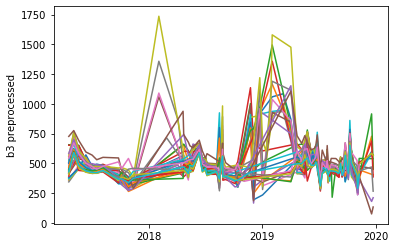

In [10]:
t_start = time.time()

time_series = getTimeSeriesForStarmap(*bboxes[0])
plot_time_series(time_series)



duration = time.time() - t_start
print(f'{duration} seconds')